In [1]:
import clip
import torch
from torch.nn.functional import normalize
from torchvision.transforms import ToTensor
import numpy as np

from submodules.CLIP_PAE.utils import get_embeddings_from_text_file, gram_schmidt, DEVICE, image_tensor_to_pre_clip

DEVICE='cuda'

# given batches of image features I and text features T,
# return targets (len(targets)=len(T)*len(I)) and the subspace basis
# targets[i*len(I) + j] is the projected embedding from T[i] and I[j]
@torch.no_grad()
def get_pae(image_features, text_features, clip_target='text', power=7.5, components=10, attribute='car_type'):
    car_type_space_basis = torch.eye(text_features.shape[1], device=DEVICE)

    if "text" in clip_target or "dpe" in clip_target:
        targets = text_features.repeat_interleave(image_features.shape[0], dim=0)
        if "dpe" in clip_target:
            if attribute == "emotion":
                if clip_target == "dpeGS":
                    car_type_texts = ["Sedan", "Coupe", "Convertible", "SUV", "Minivan", "Hatchback", "Sports Car", "Luxury Car", "Compact Car", "Off-road", "Vintage Car", "Supercar"]
                    car_types = clip.tokenize(car_type_texts).to(DEVICE)
                    car_type_features = normalize(clip_model.encode_text(car_types))
                    car_type_space_basis = gram_schmidt(car_type_features).T
                elif clip_target == "dpePCA":
                    car_type_space_basis = get_pae_PCA_basis(n_components=components, attribute=attribute).T
                targets @= car_type_space_basis
            else:
                raise NotImplementedError
    else:
        # projection
        if "All" in clip_target:
            all_car_type_embeddings = get_embeddings_from_text_file(f"data/{attribute}")
            sim_scores = normalize(image_features) @ normalize(all_car_type_embeddings).T
            if "ExD" in clip_target:
                sort_indices = sim_scores.sort(descending=True).indices
                to_deduct_per_img = torch.stack(
                    [all_car_type_embeddings[each_sort_indices[:int(power)]].sum() for each_sort_indices in sort_indices])
            else:
                max_indices = sim_scores.max(dim=-1).indices
                to_deduct_per_img = torch.stack(
                    [power * all_car_type_embeddings[each_max_indices] for each_max_indices in max_indices])
        elif "PCA" in clip_target:
            subspace_basis = get_pae_PCA_basis(n_components=components, attribute=attribute)
            text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
        else:
            if attribute == "car_type" or attribute == "car_type_ext":
                semantic_basis_text = ["Sedan", "Coupe", "Convertible", "SUV", "Minivan", "Hatchback", "Sports Car", "Luxury Car", "Compact Car", "Off-road", "Vintage Car", "Supercar"]
            else:
                raise NotImplementedError

            subspace_basis = clip.tokenize(semantic_basis_text).to(DEVICE)
            subspace_basis = normalize(clip_model.encode_text(subspace_basis))
            text_coeff_sum = torch.ones(text_features.shape[0], device=DEVICE, dtype=text_features.dtype)

            if "GS" in clip_target:
                subspace_basis = gram_schmidt(subspace_basis)
                text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
        image_coeff = image_features @ subspace_basis.T
        image_coeff = power * abs(image_coeff)

        # augmentation
        targets = []
        for i, text_feature in enumerate(text_features):
            for j, image_feature in enumerate(image_features):
                target = image_feature.clone()
                if "Ex" in clip_target:
                    target = image_feature + power * text_feature - to_deduct_per_img[j]
                elif "+" in clip_target:
                    shift = 0
                    for k, basis_vector in enumerate(subspace_basis):
                        coeff = image_coeff[j][k]
                        shift += coeff
                        target -= coeff * basis_vector
                    target += shift / text_coeff_sum[i] * text_feature
                else: # pae
                    target += power * text_feature
                targets.append(target)
        targets = torch.stack(targets)
    return targets, car_type_space_basis


In [2]:
# Basic Augmentation

@torch.no_grad()
def get_pae(image_features, text_features, clip_target='text', power=7.5, components=10, attribute='car_type'):
    car_type_space_basis = torch.eye(text_features.shape[1], device=DEVICE)
    
    # projection
    if "All" in clip_target:
        all_car_type_embeddings = get_embeddings_from_text_file(f"data/{attribute}")
        sim_scores = normalize(image_features) @ normalize(all_car_type_embeddings).T
        if "ExD" in clip_target:
            sort_indices = sim_scores.sort(descending=True).indices
            to_deduct_per_img = torch.stack(
                [all_car_type_embeddings[each_sort_indices[:int(power)]].sum() for each_sort_indices in sort_indices])
        else:
            max_indices = sim_scores.max(dim=-1).indices
            to_deduct_per_img = torch.stack(
                [power * all_car_type_embeddings[each_max_indices] for each_max_indices in max_indices])
    elif "PCA" in clip_target:
        subspace_basis = get_pae_PCA_basis(n_components=components, attribute=attribute)
        text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
    else:
        if attribute == "car_type" or attribute == "car_type_ext":
            semantic_basis_text = ["Sedan", "Coupe", "Convertible", "SUV", "Minivan", "Hatchback", "Sports Car", "Luxury Car", "Compact Car", "Off-road", "Vintage Car", "Supercar"]
        else:
            raise NotImplementedError

        subspace_basis = clip.tokenize(semantic_basis_text).to(DEVICE)
        subspace_basis = torch.nn.functional.normalize(clip_model.encode_text(subspace_basis))
        text_coeff_sum = torch.ones(text_features.shape[0], device=DEVICE, dtype=text_features.dtype)

        if "GS" in clip_target:
            subspace_basis = gram_schmidt(subspace_basis)
            text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
    image_coeff = image_features @ subspace_basis.T
    w = image_coeff @ subspace_basis
    r = image_features - w
    
    # Augmentation
    augmented = w + power * text_features
    target = augmented + r
    return target, car_type_space_basis


In [3]:
# Advanced Augmentation

@torch.no_grad()
def get_pae(image_features, text_features, clip_target='text', power=7.5, components=10, attribute='car_type'):
    car_type_space_basis = torch.eye(text_features.shape[1], device=DEVICE)
    
    # projection
    if "All" in clip_target:
        all_car_type_embeddings = get_embeddings_from_text_file(f"data/{attribute}")
        sim_scores = normalize(image_features) @ normalize(all_car_type_embeddings).T
        if "ExD" in clip_target:
            sort_indices = sim_scores.sort(descending=True).indices
            to_deduct_per_img = torch.stack(
                [all_car_type_embeddings[each_sort_indices[:int(power)]].sum() for each_sort_indices in sort_indices])
        else:
            max_indices = sim_scores.max(dim=-1).indices
            to_deduct_per_img = torch.stack(
                [power * all_car_type_embeddings[each_max_indices] for each_max_indices in max_indices])
    elif "PCA" in clip_target:
        subspace_basis = get_pae_PCA_basis(n_components=components, attribute=attribute)
        text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
    else:
        if attribute == "car_type" or attribute == "car_type_ext":
            semantic_basis_text = ["Sedan", "Coupe", "Convertible", "SUV", "Minivan", "Hatchback", "Sports Car", "Luxury Car", "Compact Car", "Off-road", "Vintage Car", "Supercar"]
        else:
            raise NotImplementedError

        subspace_basis = clip.tokenize(semantic_basis_text).to(DEVICE)
        subspace_basis = torch.nn.functional.normalize(clip_model.encode_text(subspace_basis))
        text_coeff_sum = torch.ones(text_features.shape[0], device=DEVICE, dtype=text_features.dtype)

        if "GS" in clip_target:
            subspace_basis = gram_schmidt(subspace_basis)
            text_coeff_sum = (text_features @ subspace_basis.T).sum(dim=-1)
    image_coeff = image_features @ subspace_basis.T
    w = image_coeff @ subspace_basis
    r = image_features - w
    # Augmentation
    c = []
    for i, b in enumerate(subspace_basis):
        c.append(w @ b.unsqueeze(0).T)

    d = []
    text_coeff = text_features @ subspace_basis.T
    p_text = text_coeff @ subspace_basis
    for i, b in enumerate(subspace_basis):
        d.append(p_text @ b.unsqueeze(0).T)
    
    weakening = torch.zeros(image_features.shape, device=DEVICE)
    for i, c_k in enumerate(c):
        weakening += (c_k.item() - power * abs(c_k.item()) * subspace_basis[i])

    upper = 0
    for i, c_k in enumerate(c):
        upper += abs(c_k.item())
    upper *= power
    
    lower = 0
    for i, d_k in enumerate(d):
        lower += d_k.item()
    
    augmented = weakening + (upper/lower) * p_text
    
    target = augmented + r
    return target, car_type_space_basis


In [4]:
from os import path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import resize, normalize, center_crop

@torch.no_grad()
def get_pae_PCA_basis(n_components=10, attribute="car_type"):
    basis_path = f"data/corpus/{attribute}_space_basis_{n_components}.pt"
    if path.exists(basis_path):
        return torch.load(basis_path, map_location=DEVICE)

    # No precomputed basis. Compute now
    all_embeddings = get_embeddings_from_text_file(f"data/corpus/{attribute}")
    type_before = all_embeddings.dtype
    all_embeddings = StandardScaler().fit_transform(all_embeddings.cpu().numpy())
    pca = PCA(n_components=n_components)
    pca.fit(all_embeddings)
    basis = torch.from_numpy(pca.components_).to(DEVICE).to(type_before)
    torch.save(basis, basis_path)
    return basis

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip.load("ViT-B/32", device="cpu")[0].to(device)

In [6]:
import pickle
import copy

from clip_utils.clip_loss import CLIPLoss
from training_utils.training_utils import get_lr
from get3d_utils import constructGenerator, eval_get3d_single

def preprocess_rgb_grid(array):
    gh = 1

    lo, hi = -1, 1
    img = array
    img = (img - lo) * (255 / (hi - lo))
    img.clip(0, 255)

    _N, C, H, W = img.shape
    gw = _N // gh
    img = img.reshape([gh, gw, C, H, W])
    img = img.transpose(0, 3, 1, 4, 2)
    img = img.reshape([gh * H, gw * W, C])
    return img.astype(np.uint8)

with open('test.pickle', 'rb') as f:
    generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [7]:
torch.manual_seed(0)

imgs = []
geo_latents = []
tex_latents = []

with torch.no_grad():
    g_ema = copy.deepcopy(G_ema).eval()
    for i in range(100):
        z = torch.randn([1, 512], device='cuda')  # random code for geometry
        tex_z = torch.randn([1, 512], device='cuda')  # random code for texture
        c = torch.ones(1, device='cuda')
        output = eval_get3d_single(g_ema, z, tex_z, c)
        geo_latents.append(z)
        tex_latents.append(tex_z)
        imgs.append(output)

/home/windows-ssh/git/GET3D/training/networks_get3d.py:467: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device=self.device).unsqueeze(dim=-1) / n_camera * math.pi * 2.0
/home/windows-ssh/git/GET3D/training/networks_get3d.py:467: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device=self.device).unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [8]:
img_array = []

for img in imgs:
    img_array.append(image_tensor_to_pre_clip(img))

In [9]:
car_types = [
    "Sedan",
    "Coupe",
    "Convertible",
    "Hatchback",
    "Station Wagon",
    "SUV (Sport Utility Vehicle)",
    "Crossover",
    "Minivan",
    "Pickup Truck",
    "Roadster",
    "Sports Car",
    "Muscle Car",
    "Luxury Car",
    "Electric Car",
    "Hybrid Car",
    "Plug-in Hybrid",
    "Compact Car",
    "Midsize Car",
    "Full-size Car",
    "Subcompact Car",
    "Economy Car",
    "Vintage Car",
    "Classic Car",
    "Compact SUV",
    "Midsize SUV",
    "Full-size SUV",
    "Crossover SUV",
    "Compact Crossover",
    "Luxury SUV",
    "Off-road Vehicle",
    "4x4",
    "Van",
    "Camper Van",
    "Minibus",
    "Compact MPV (Multi-Purpose Vehicle)",
    "Luxury Sedan",
    "Sports Sedan",
    "Executive Car",
    "City Car",
    "Supercar",
    "Hypercar",
    "Electric SUV",
    "Electric Pickup",
    "Autonomous Car",
    "Concept Car",
    "Green Car",
    "Family Car",
    "Compact Pickup",
    "Luxury Coupe",
    "Grand Tourer (GT)",
    "Rally Car",
    "Compact Electric Car",
    "Midsize Electric Car",
    "Luxury Electric Car",
    "Electric Sports Car"
]

In [10]:
# Get CLIP Embeddings of texts
description = 'Sports Car'
text_inputs = torch.cat([clip.tokenize(description)]).cuda()
text_features = clip_model.encode_text(text_inputs)

text_embeddings = []
for type in car_types:
    type_input = torch.cat([clip.tokenize(type)]).cuda()
    type_feature = clip_model.encode_text(type_input)
    text_embeddings.append(type_feature.detach().cpu().numpy())
text_embeddings = np.array(text_embeddings)

In [11]:
# Get CLIP Embeddings of images
clip_embeddings = []
for img in img_array:
    clip_embeddings.append(clip_model.encode_image(img.to(device)).detach().cpu().numpy())
clip_embeddings = np.array(clip_embeddings)

In [12]:
# Get CLIP-PAE Embeddings of images
clip_pae_embeddings = []
for img in img_array:
    img_feature = clip_model.encode_image(img.to(device))
    targets, emotion_space_basis = get_pae(img_feature, text_features, clip_target='PCA+', components=10, power=7.5, attribute='car_type_ext')
    clip_pae_embeddings.append((targets.detach()).cpu().numpy())
clip_pae_embeddings = np.array(clip_pae_embeddings)

In [13]:
all = np.concatenate((text_embeddings, clip_embeddings, clip_pae_embeddings)).squeeze(1)

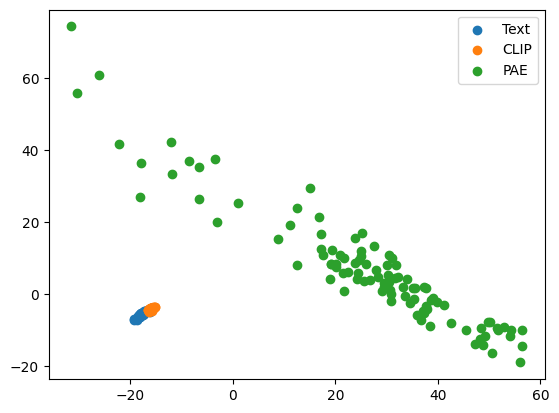

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(all)

text_pca = pca.transform(text_embeddings.squeeze(1))
clip_pca = pca.transform(clip_embeddings.squeeze(1))
pae_pca = pca.transform(clip_pae_embeddings.squeeze(1))

ax = plt.subplot(1, 1, 1)
ax.scatter(text_pca[:,0], text_pca[:,1], label='Text')
ax.scatter(clip_pca[:,0], clip_pca[:,1], label='CLIP')
ax.scatter(pae_pca[:,0], pae_pca[:,1], label='PAE')
ax.legend()
plt.show()

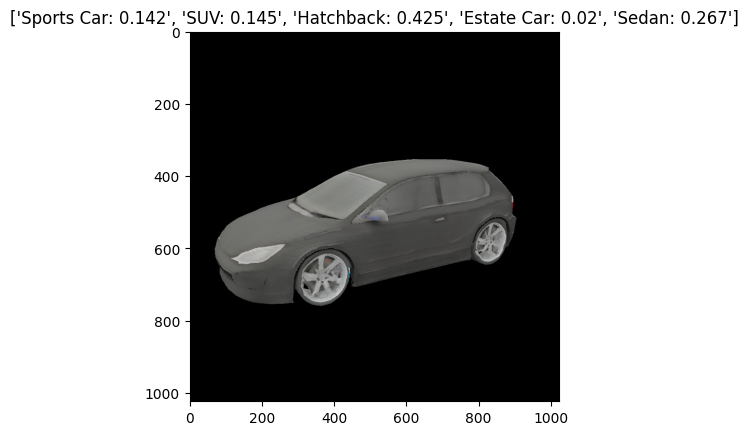

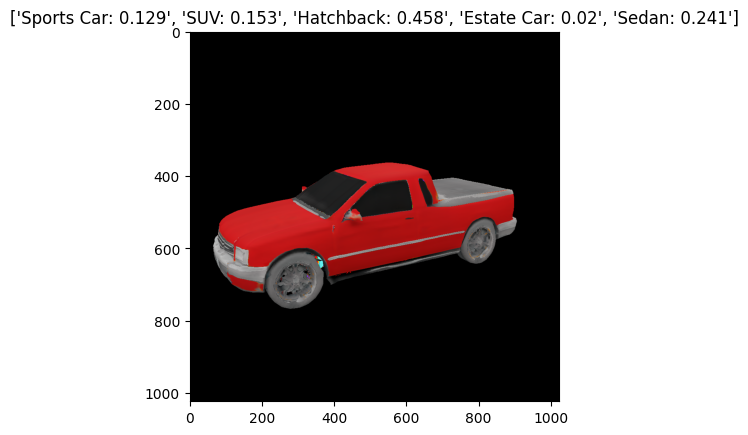

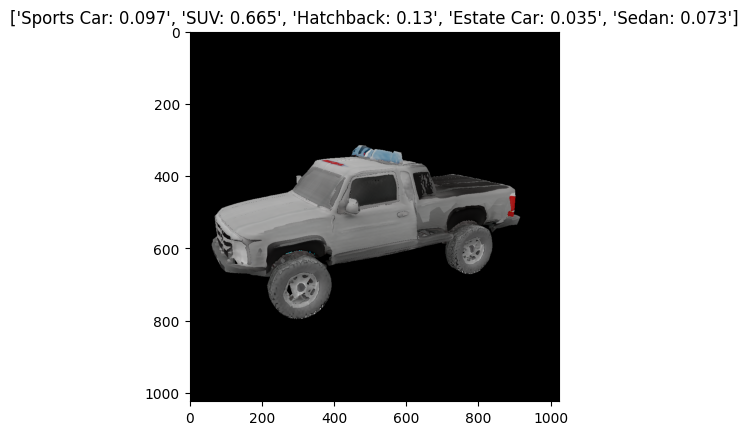

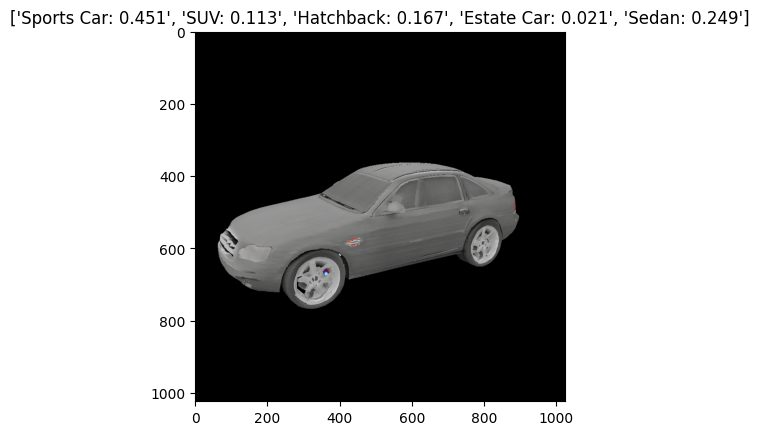

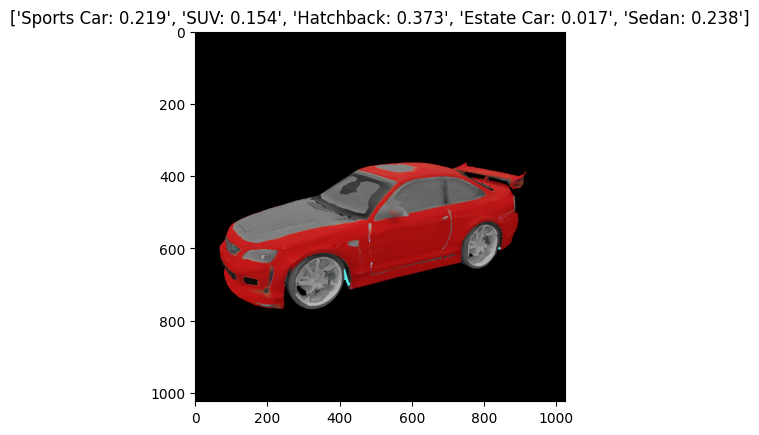

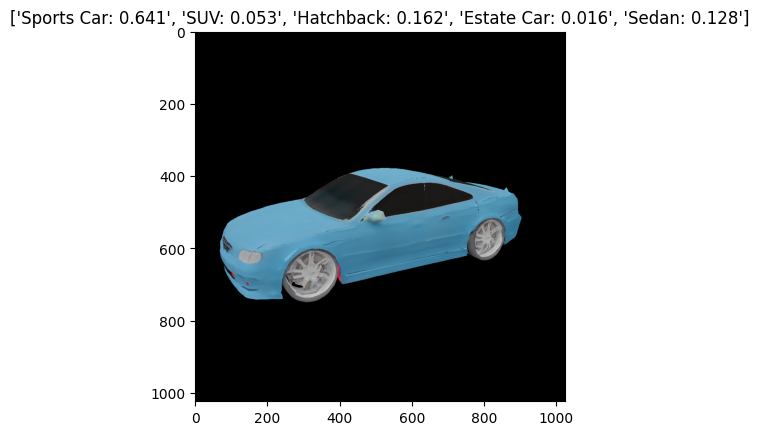

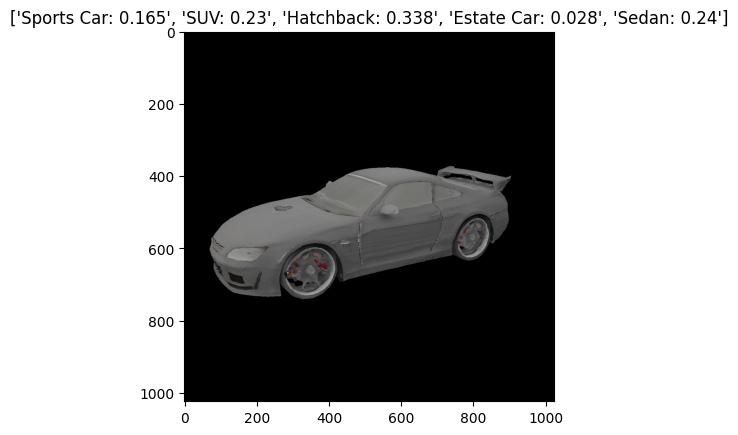

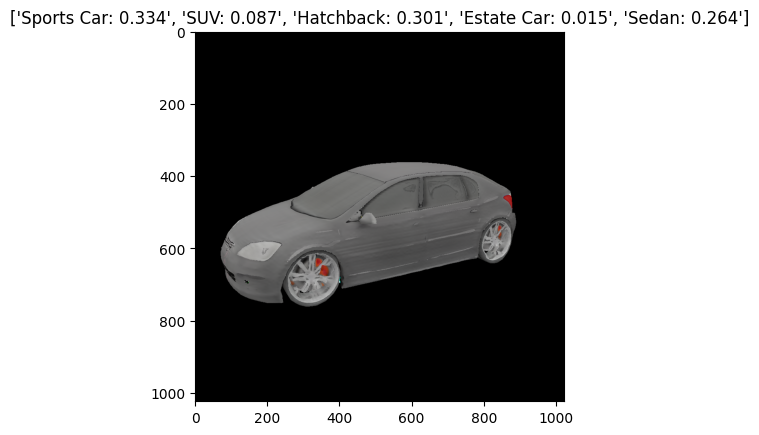

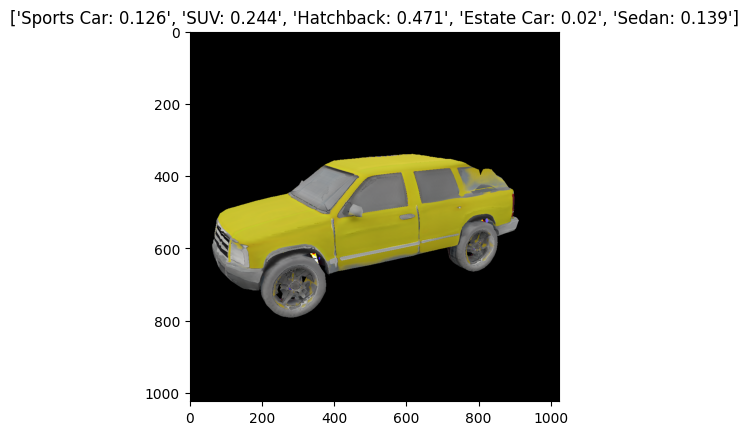

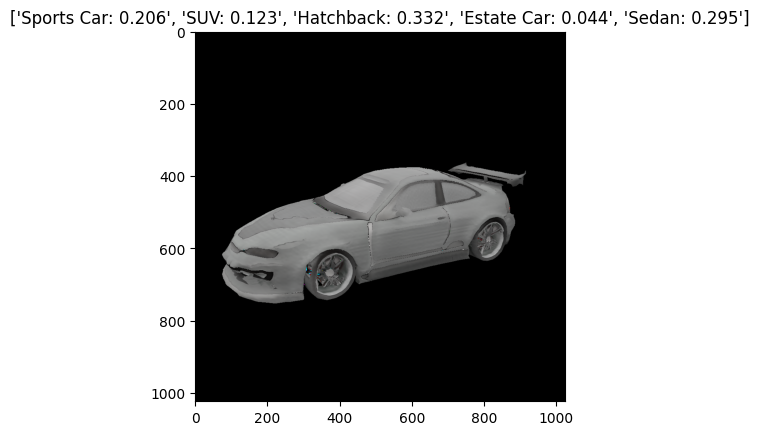

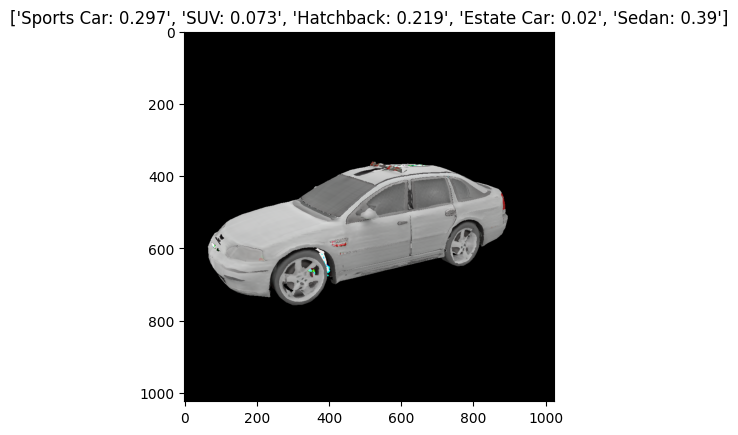

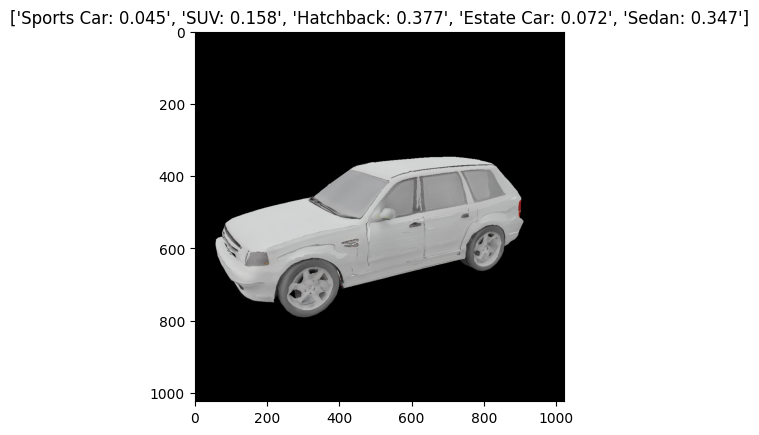

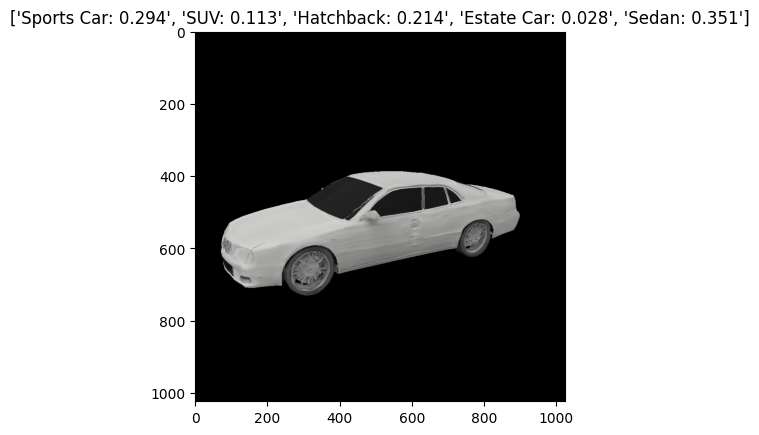

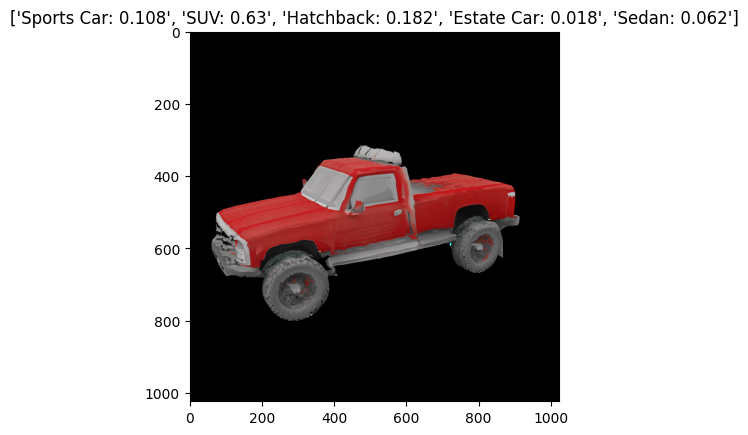

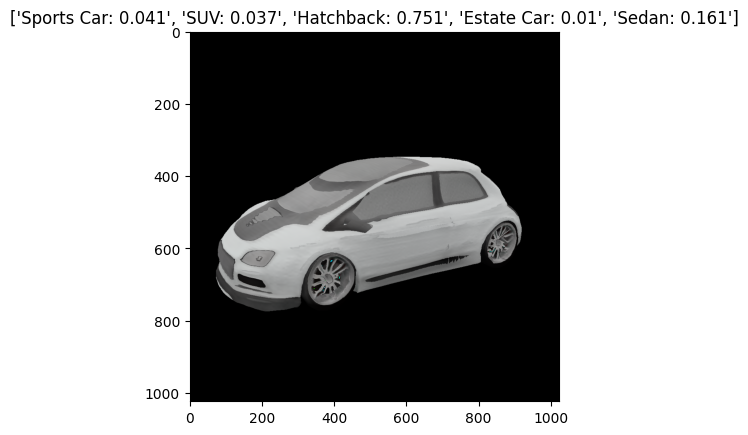

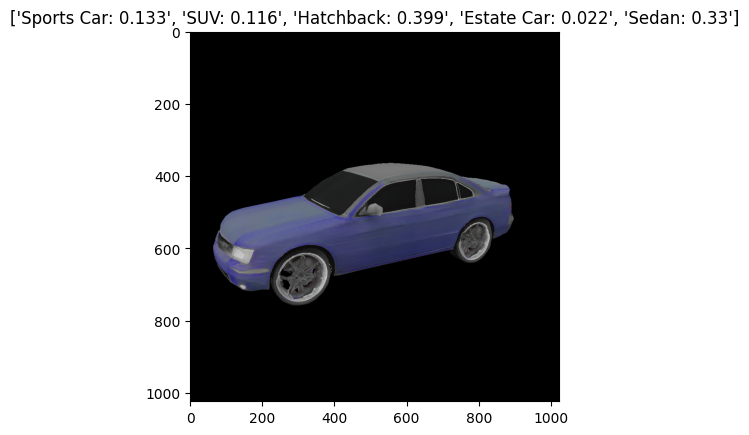

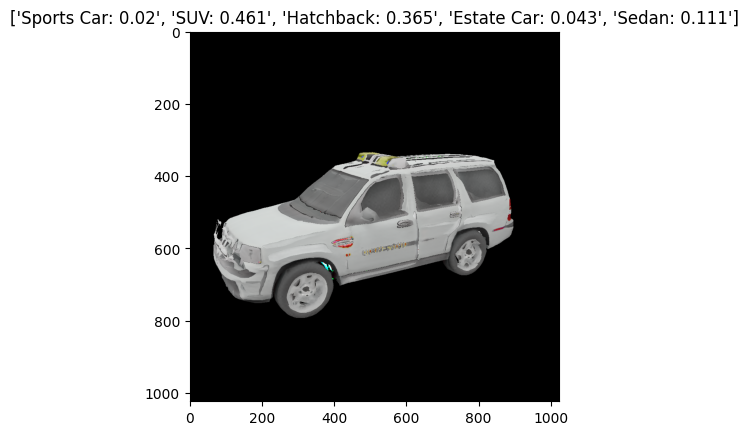

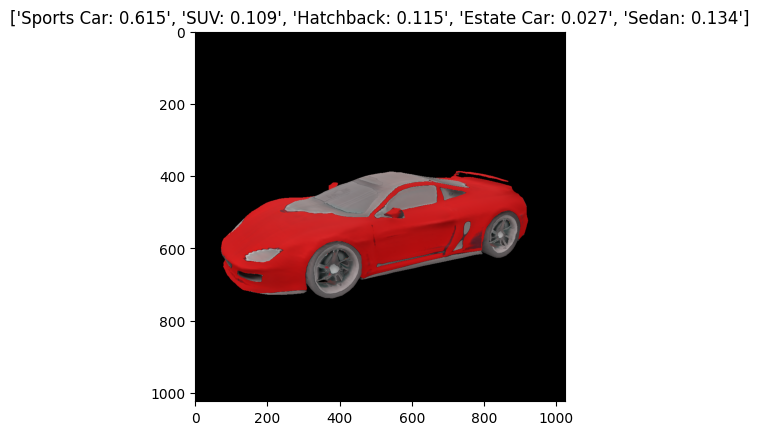

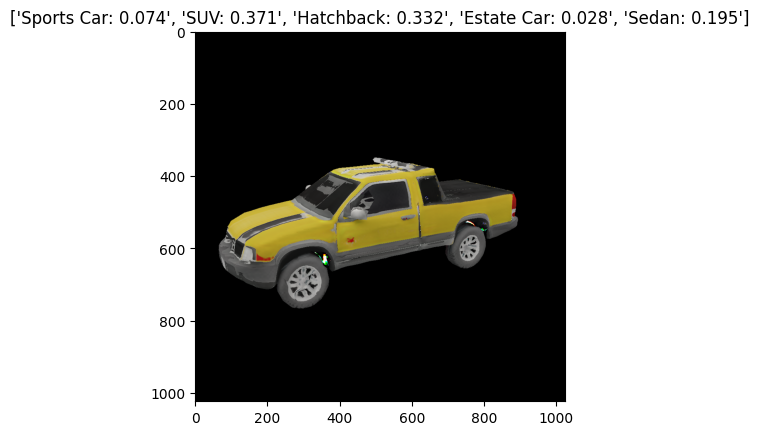

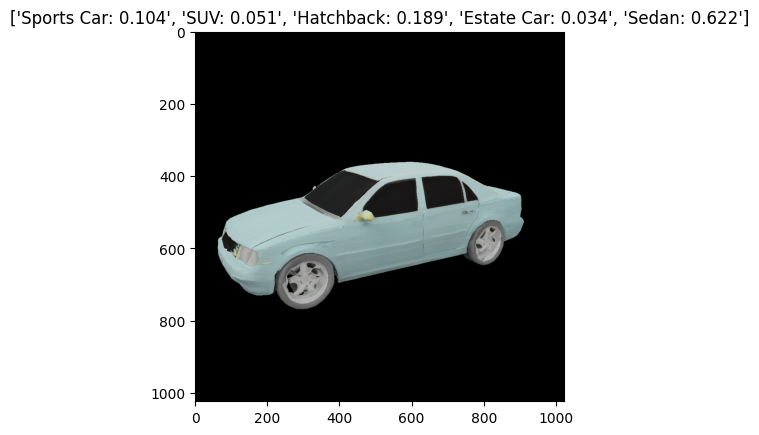

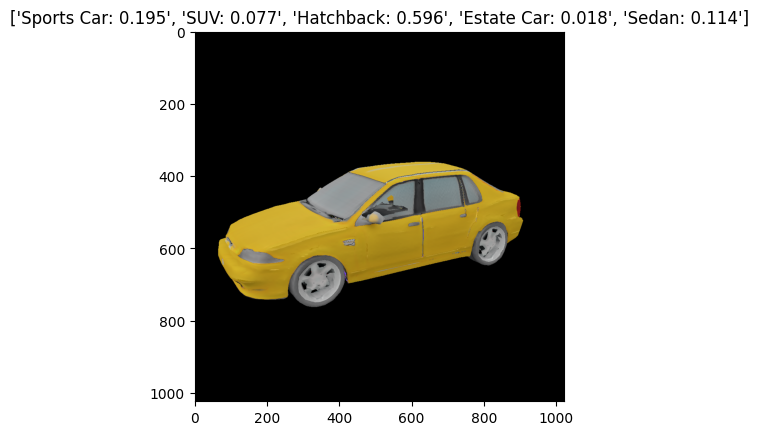

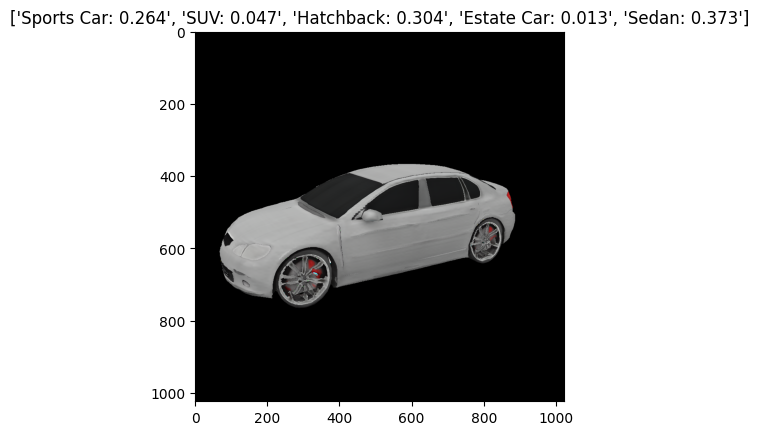

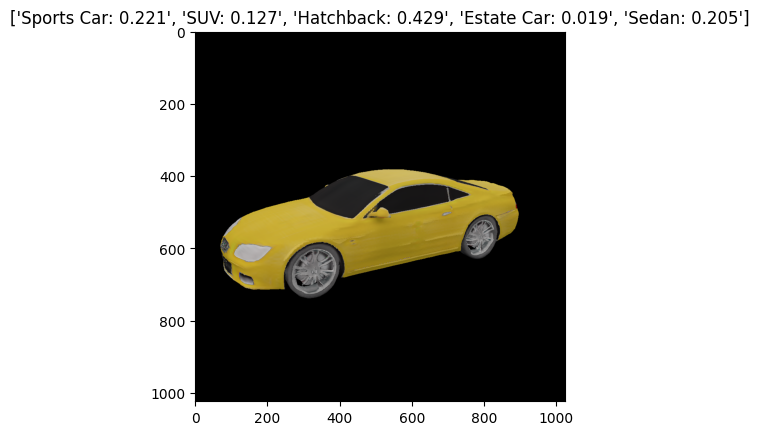

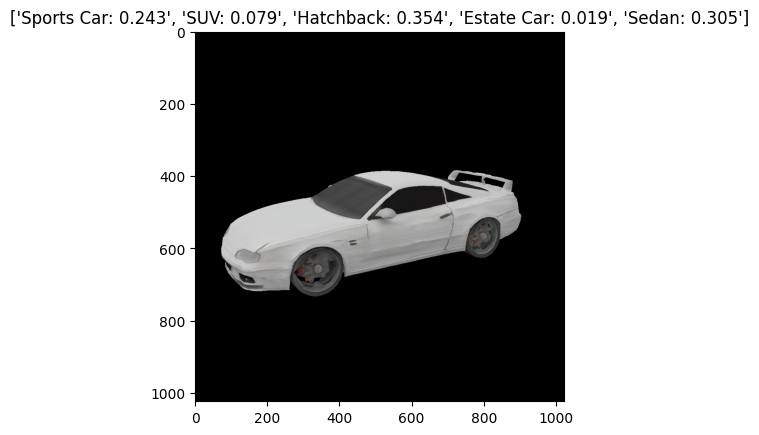

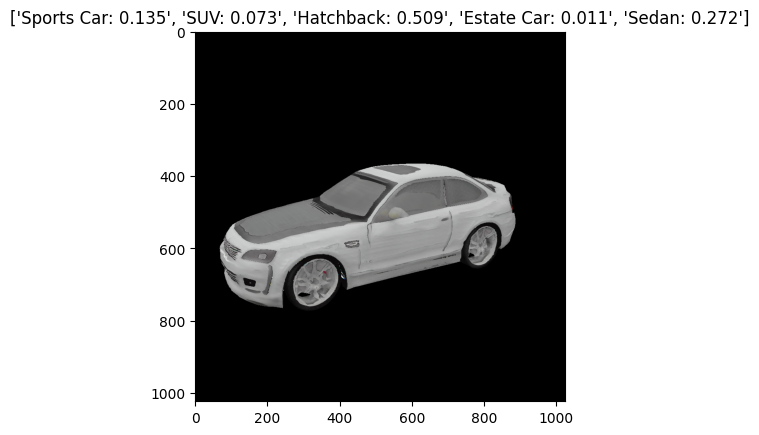

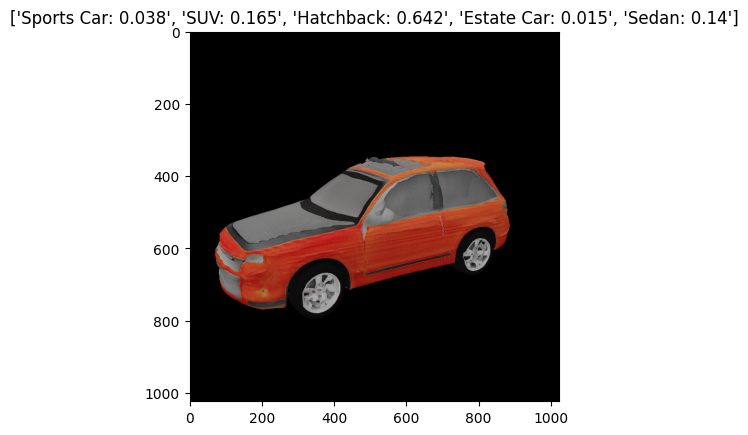

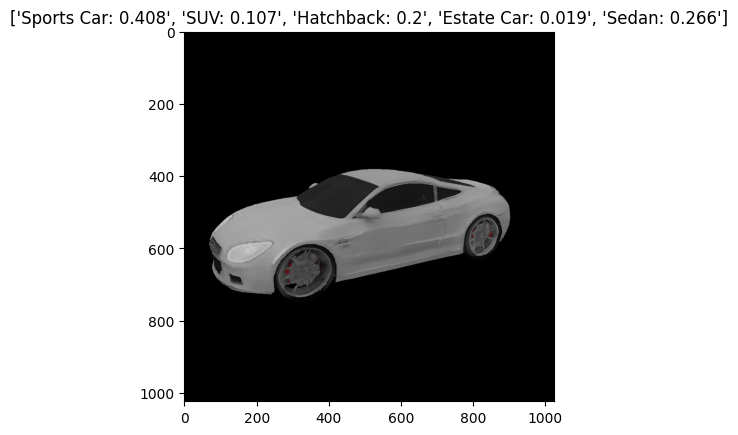

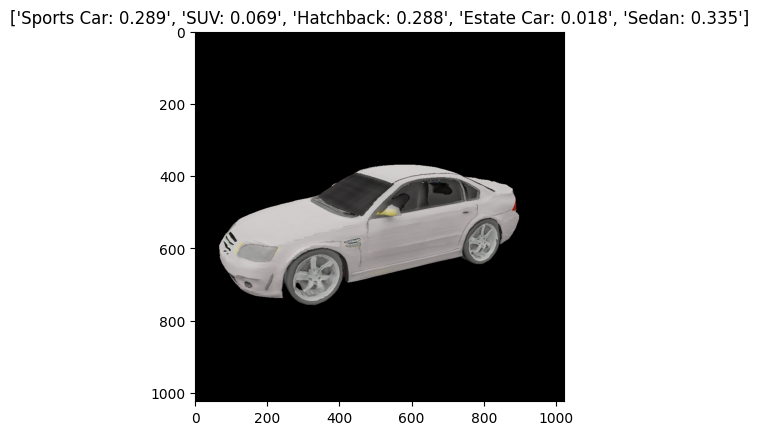

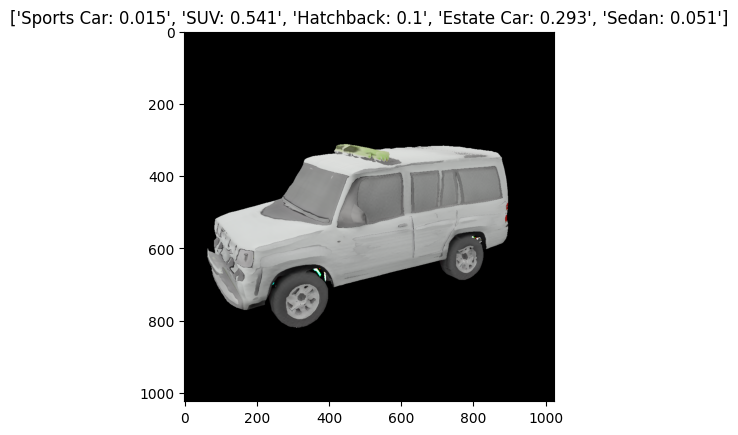

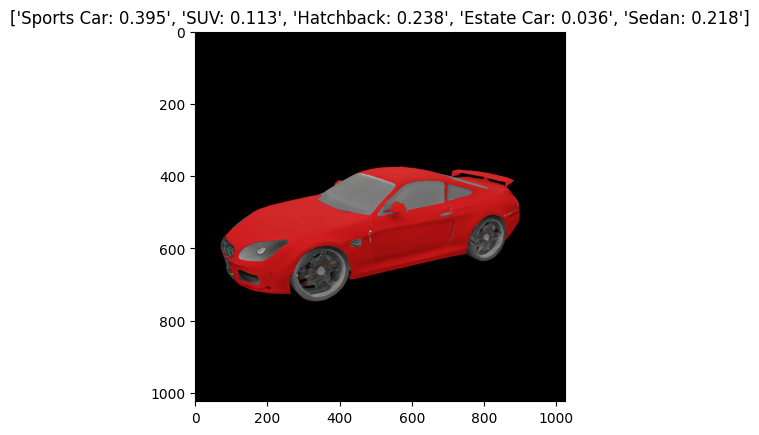

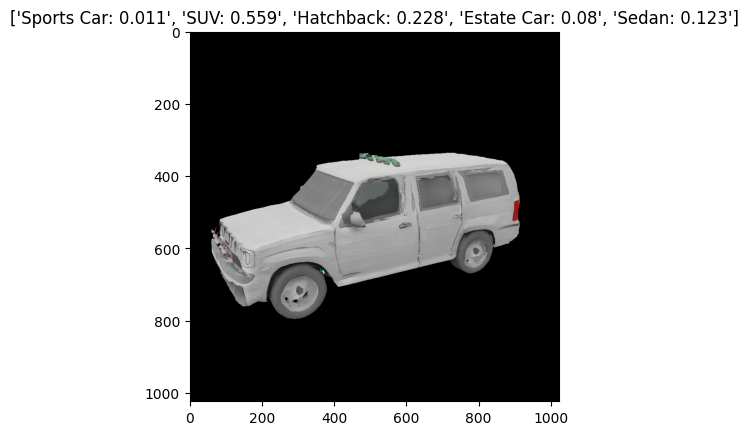

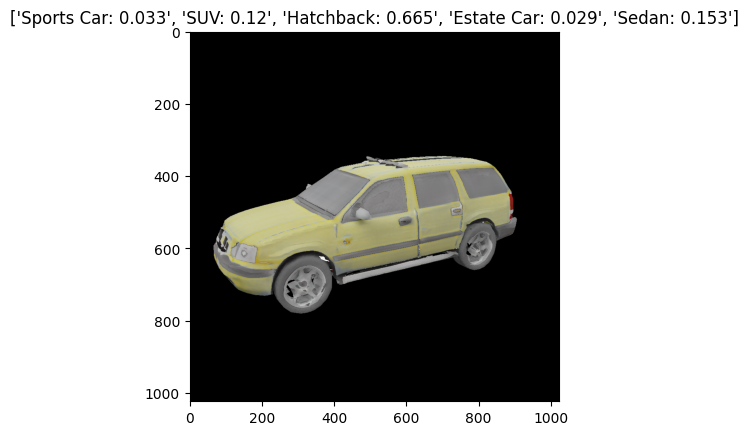

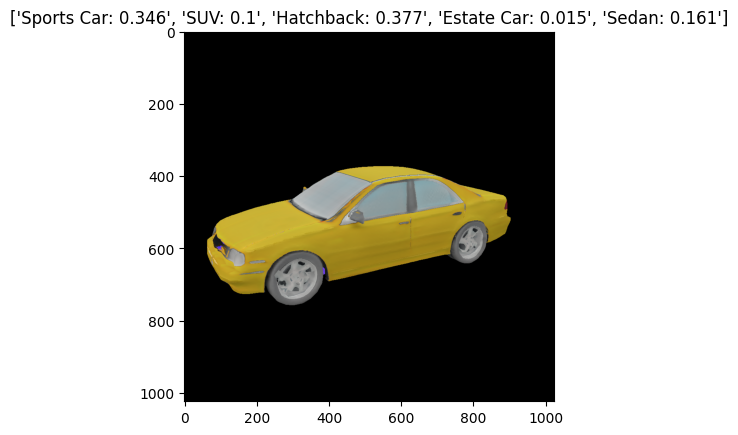

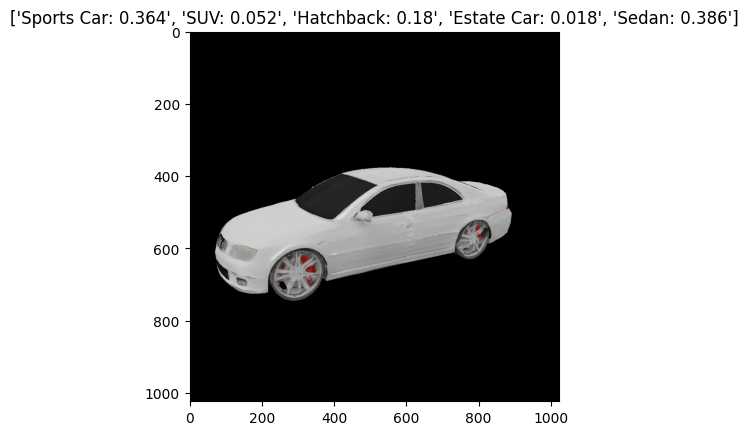

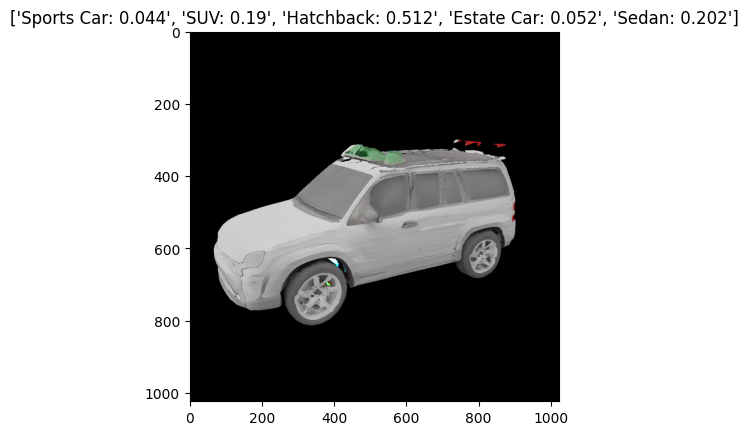

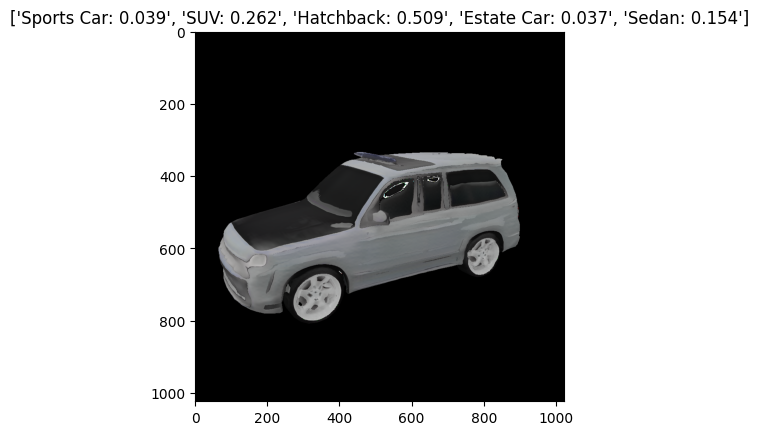

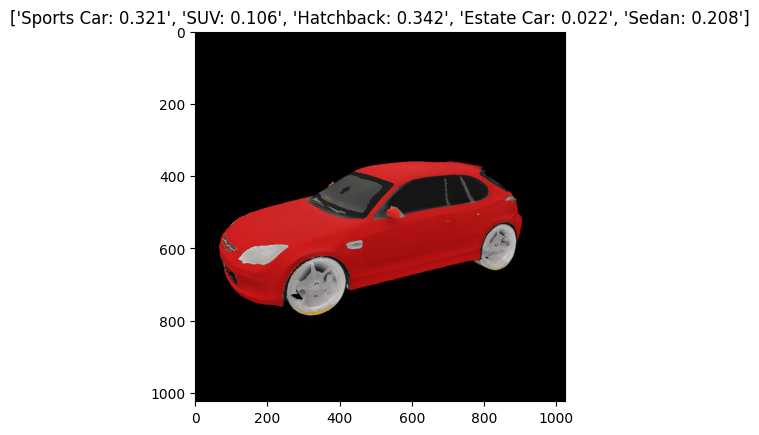

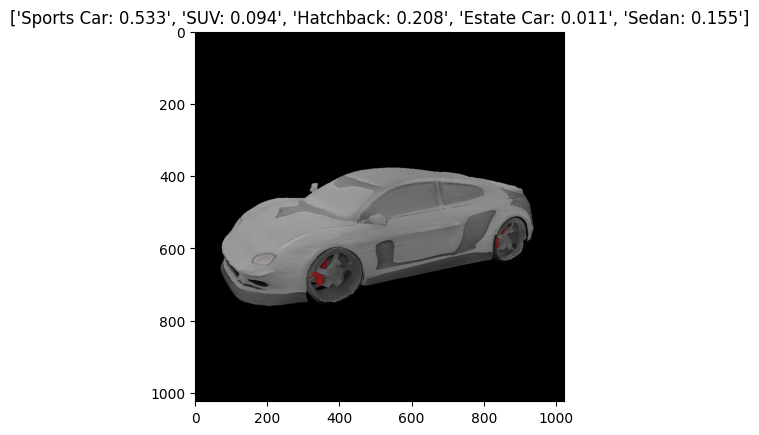

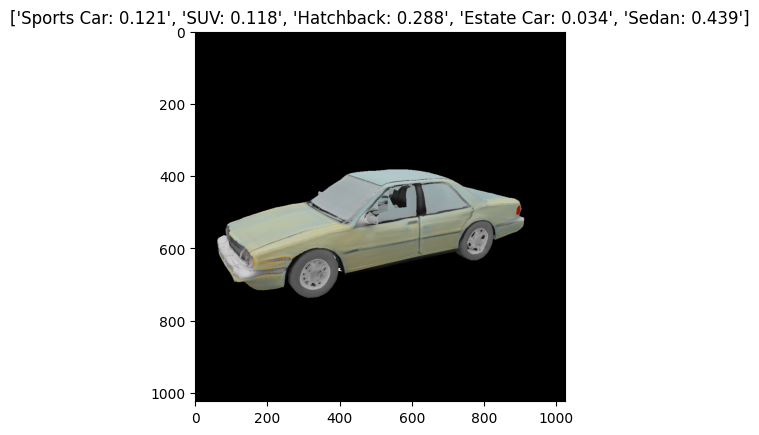

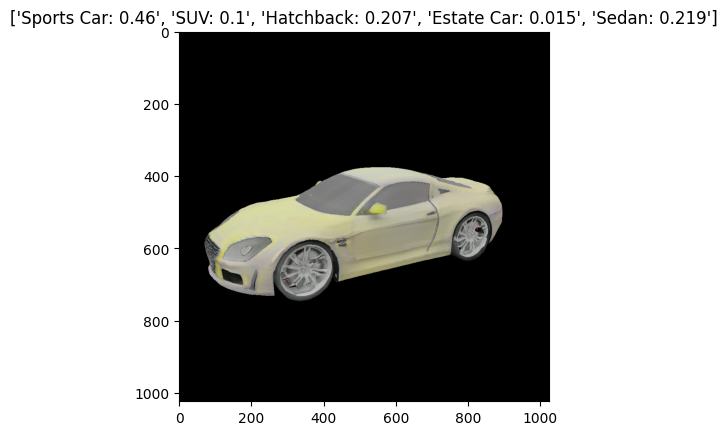

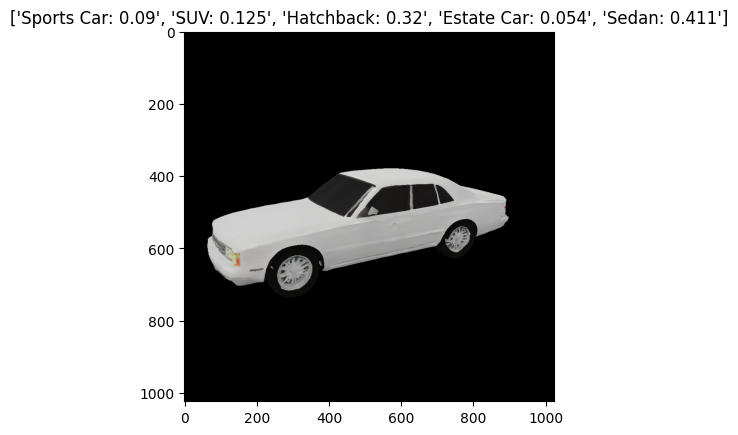

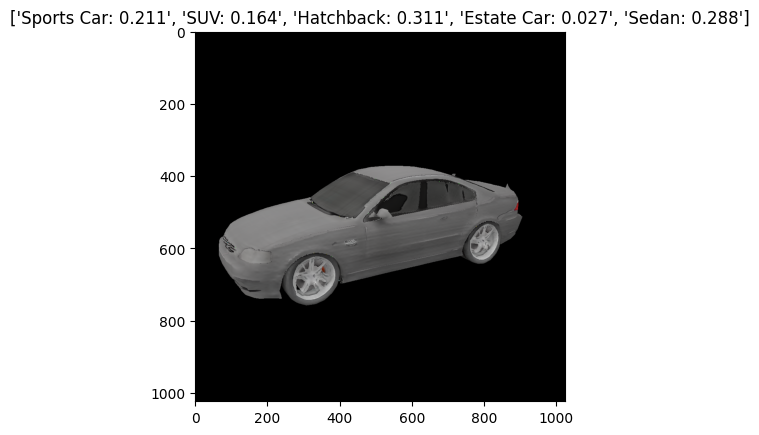

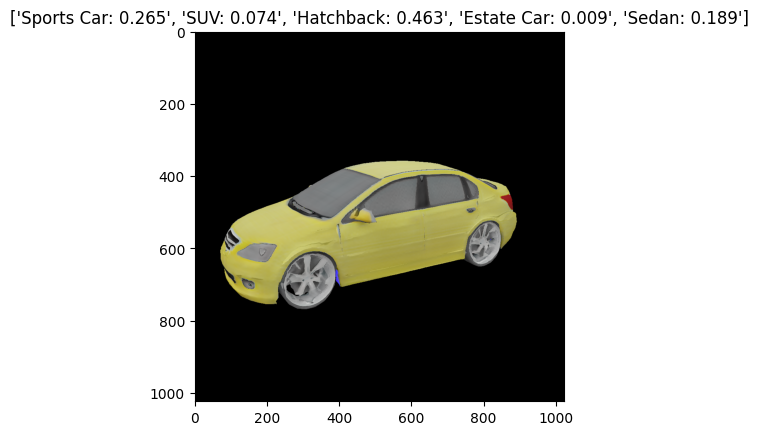

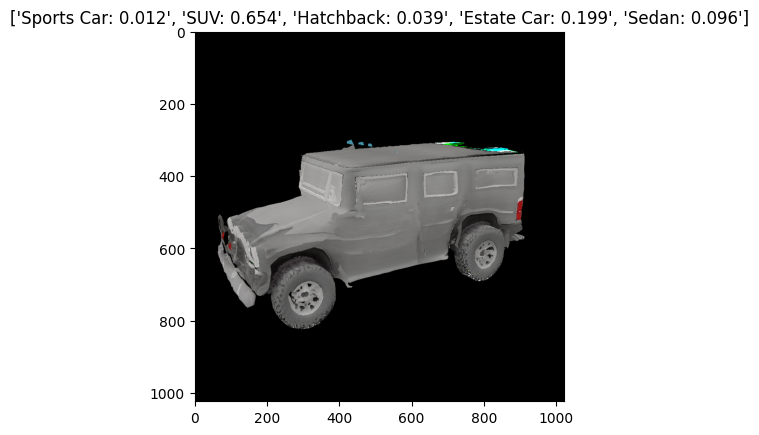

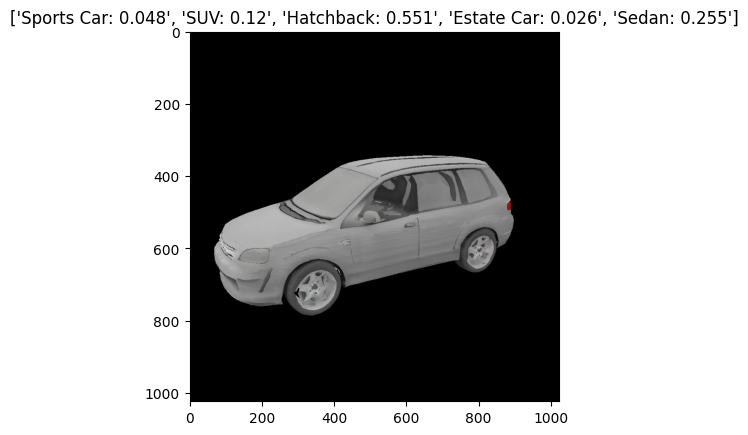

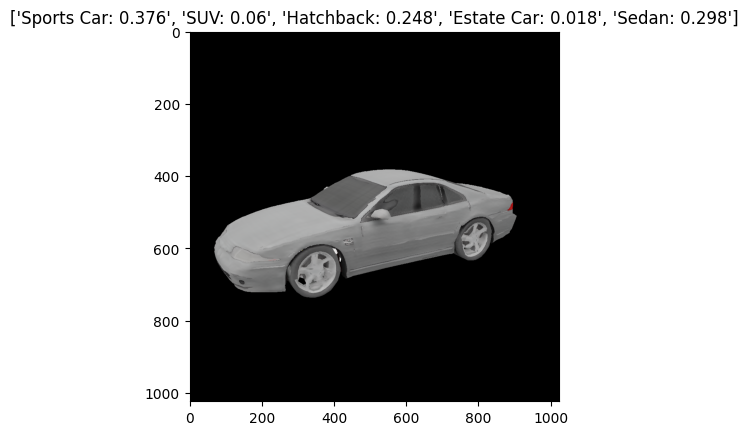

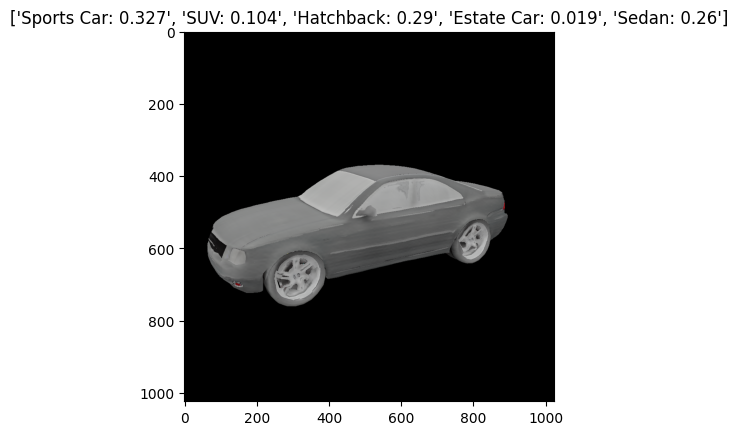

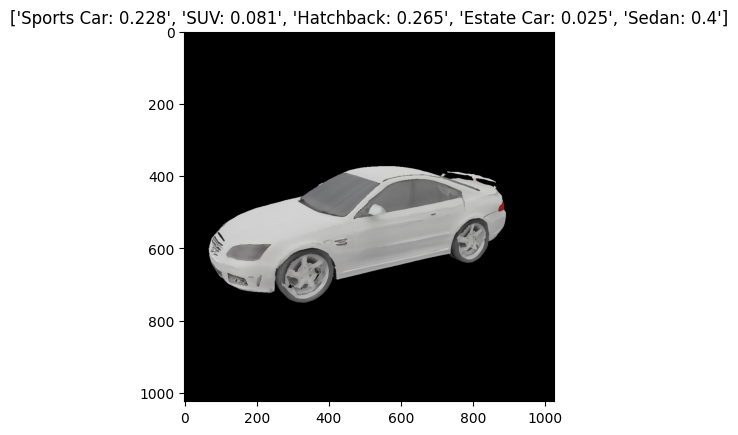

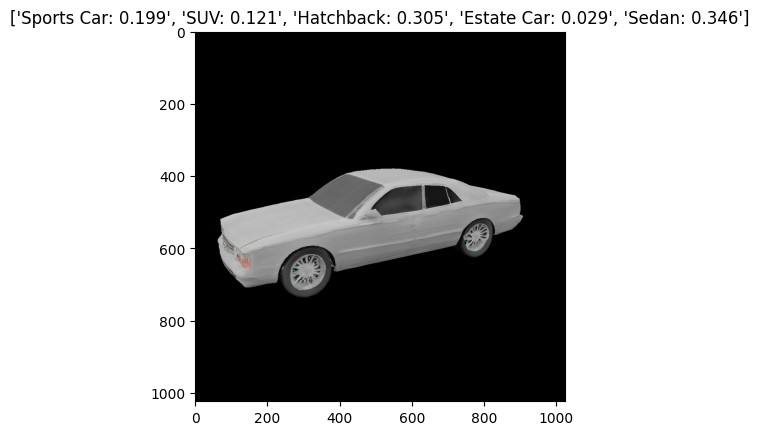

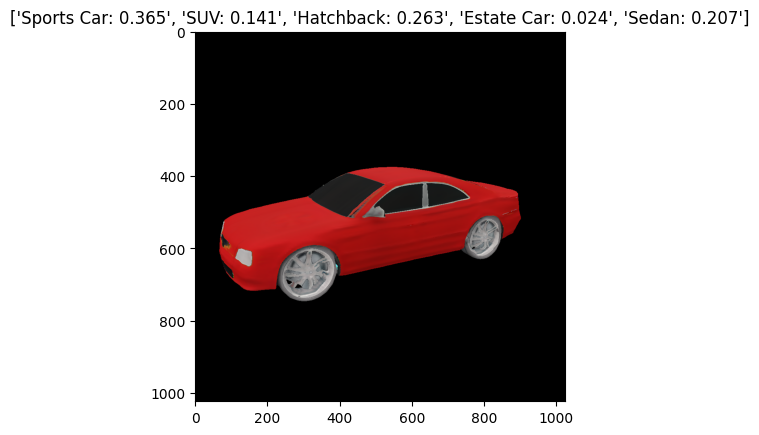

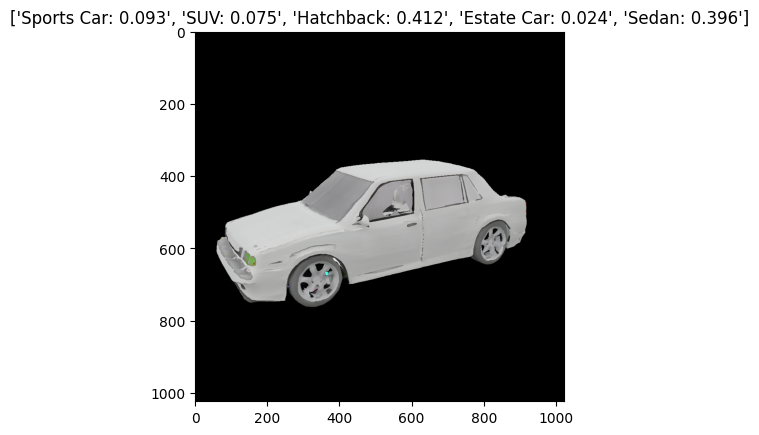

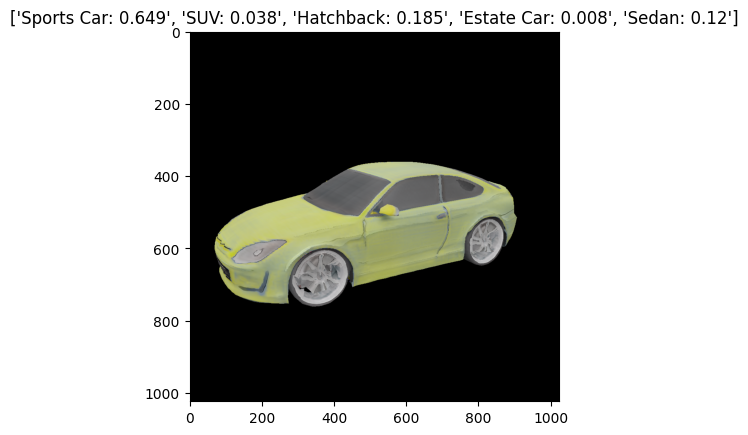

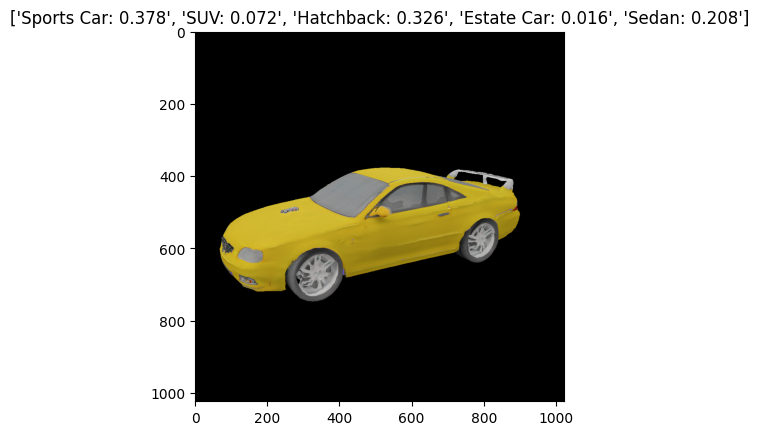

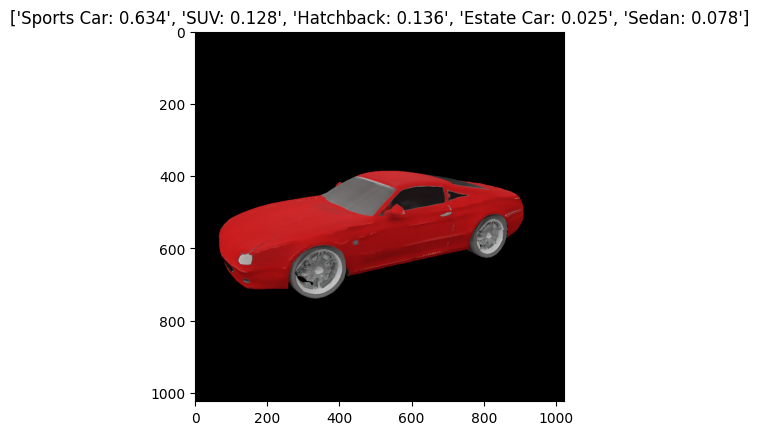

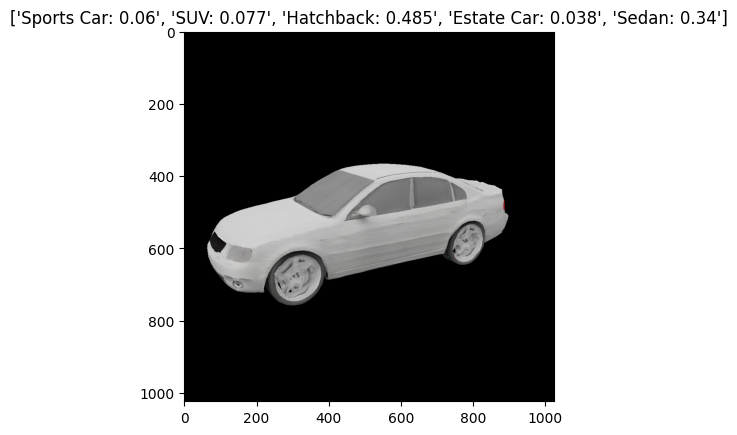

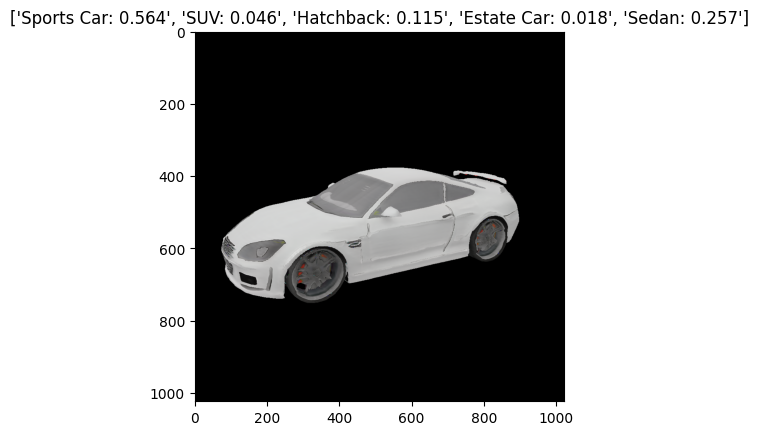

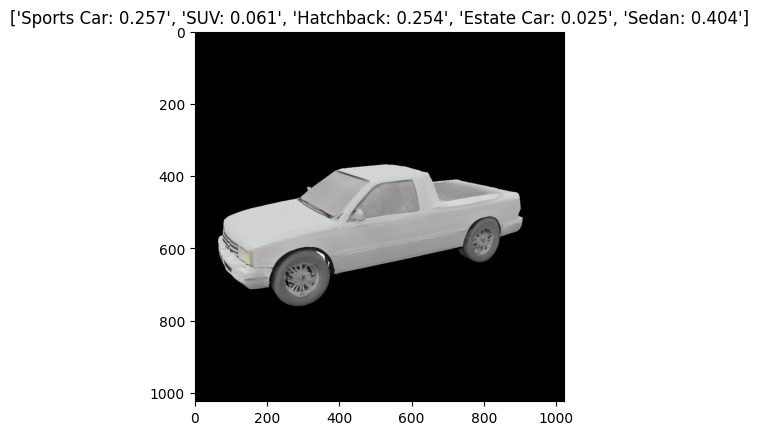

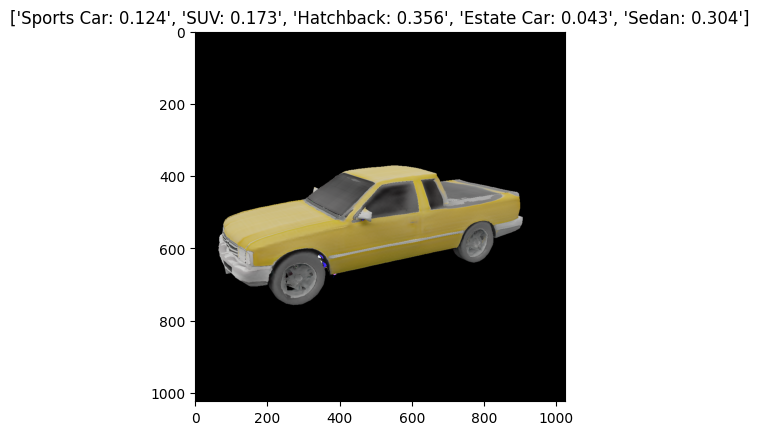

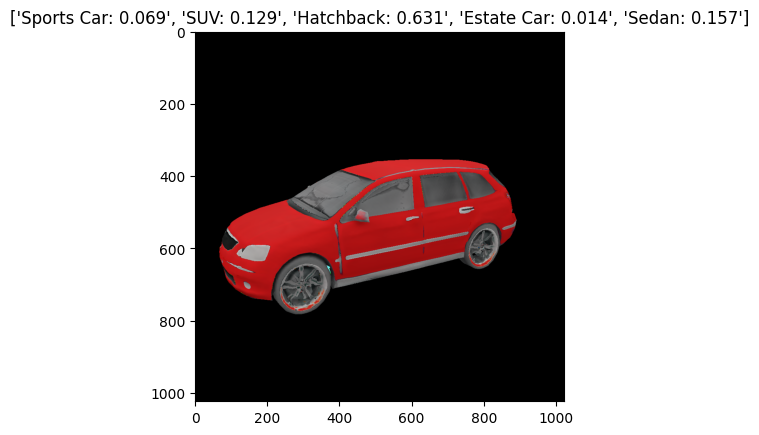

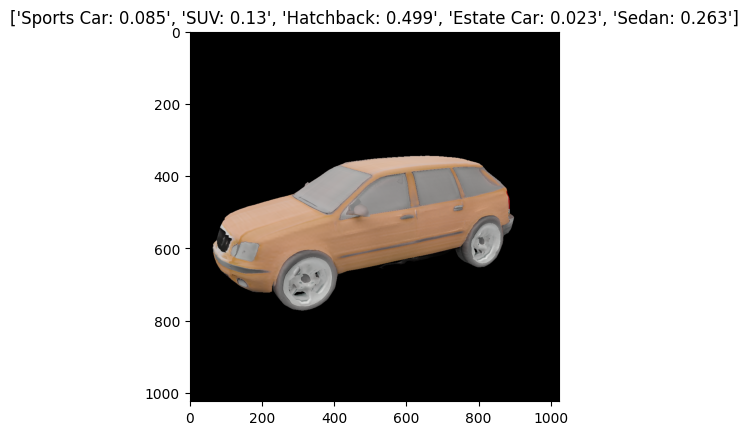

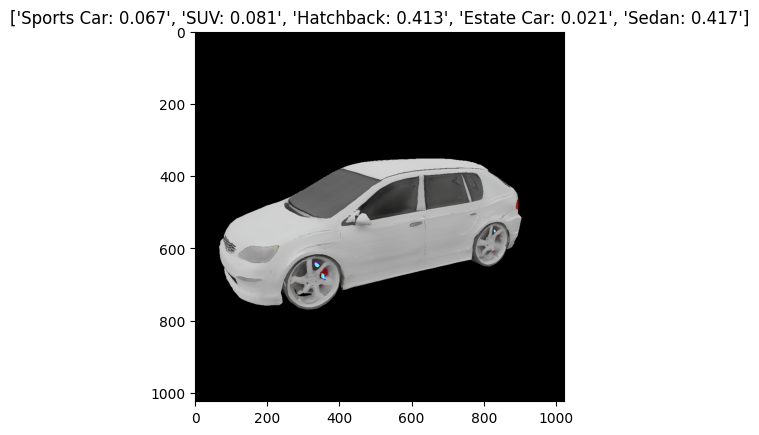

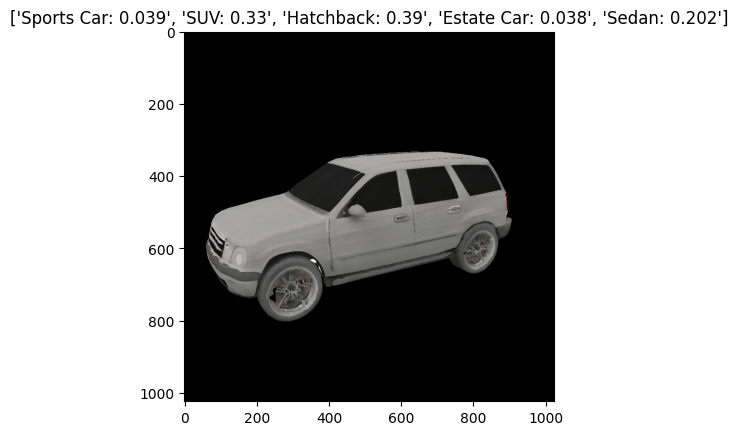

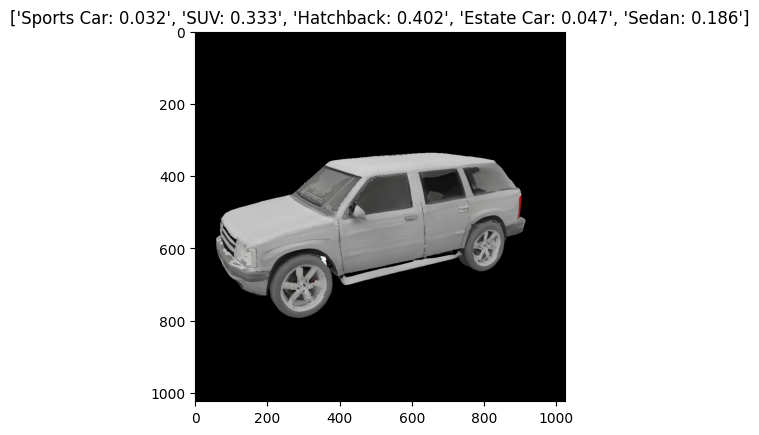

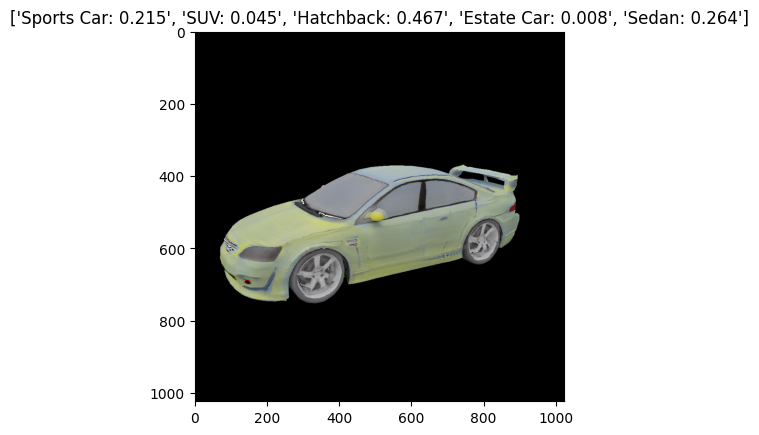

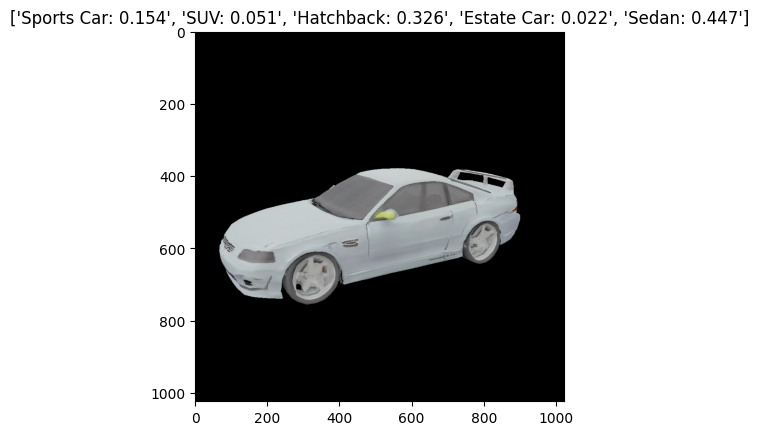

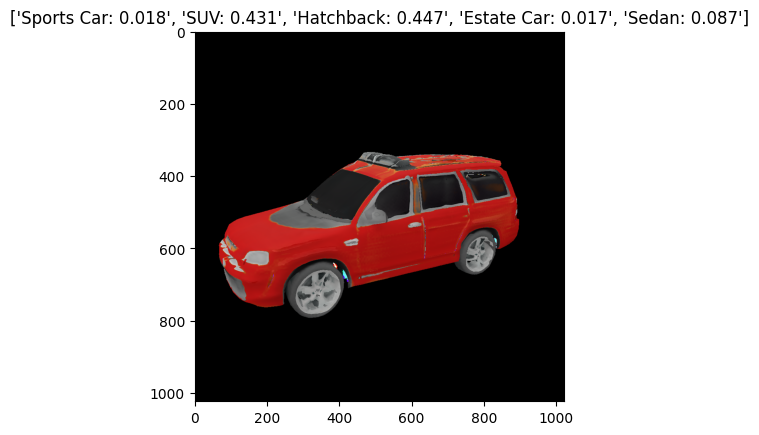

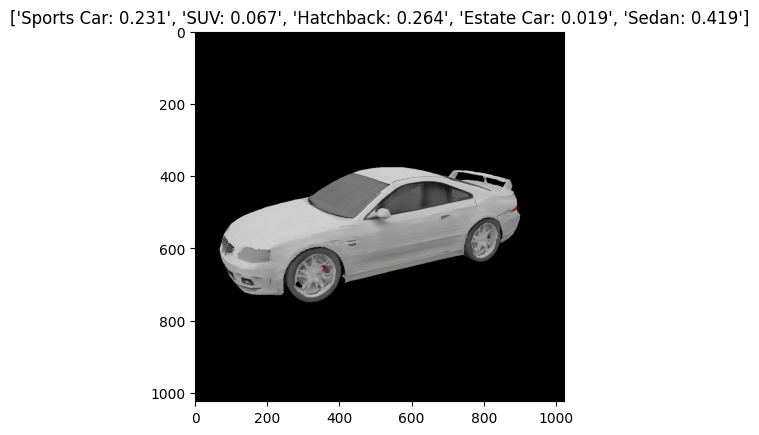

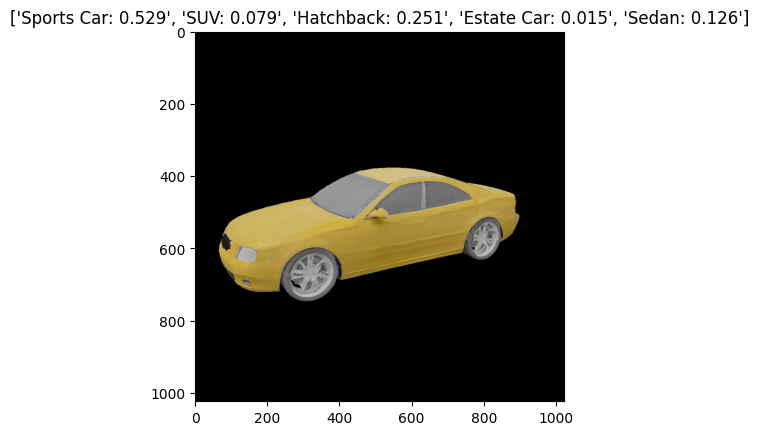

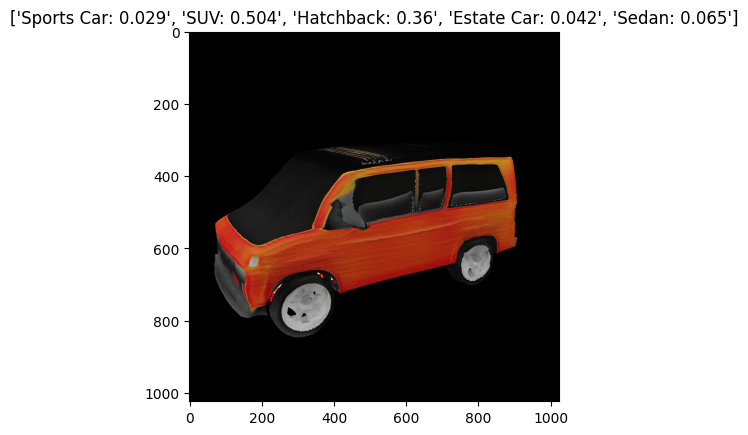

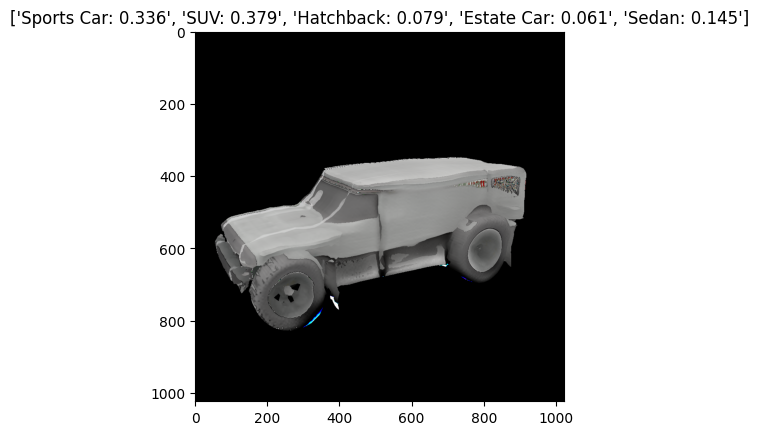

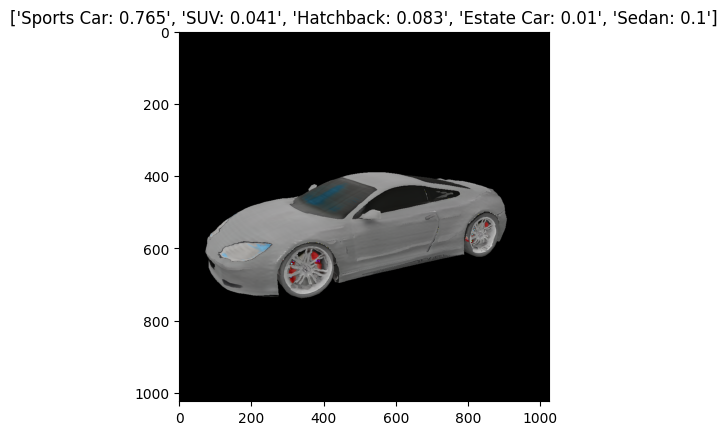

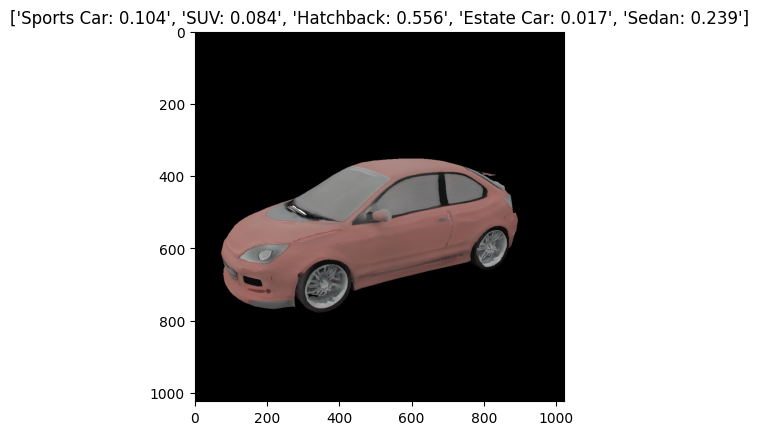

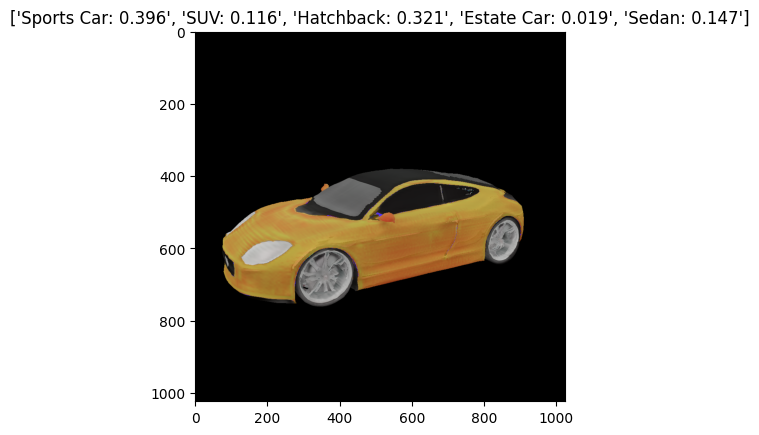

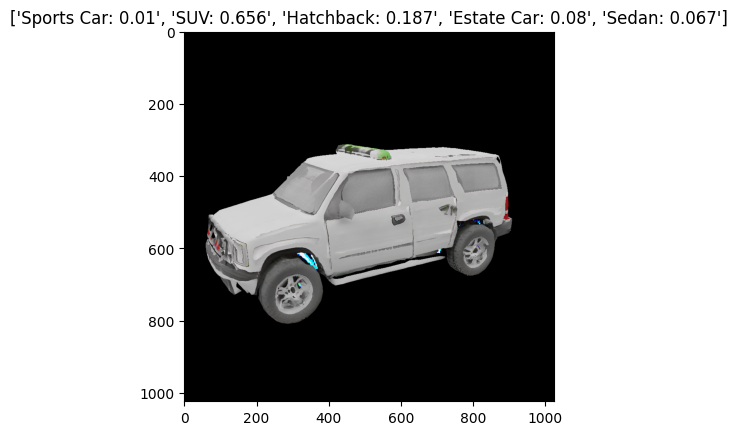

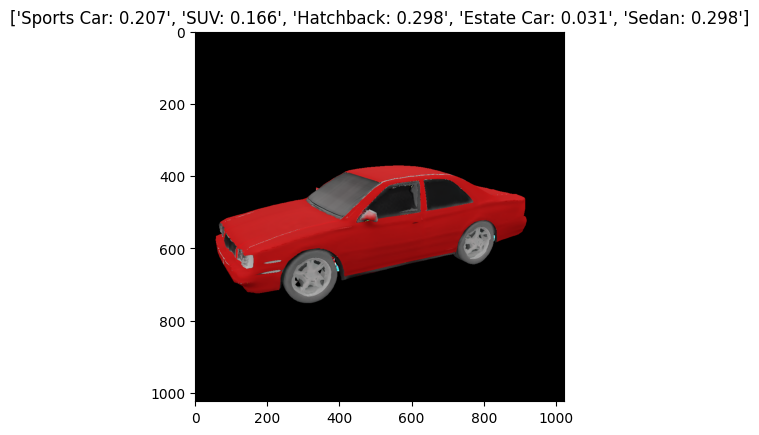

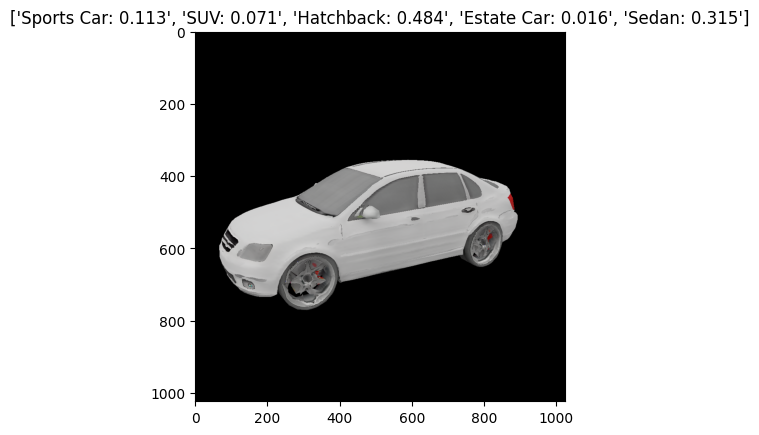

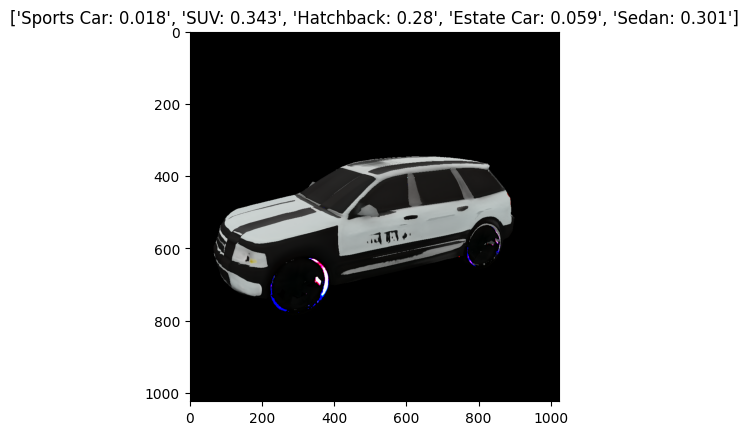

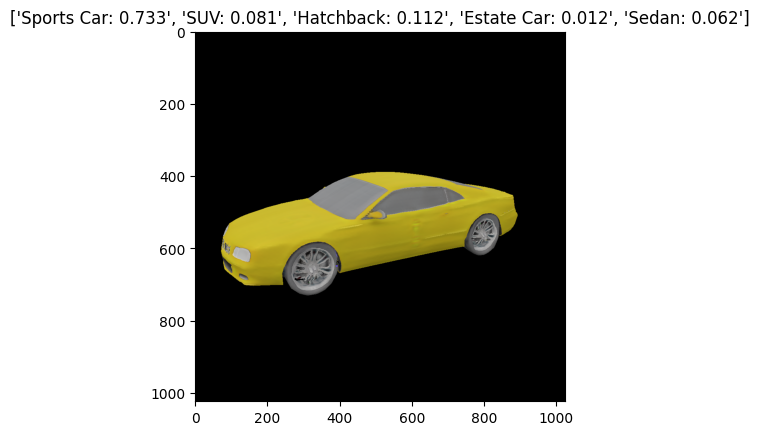

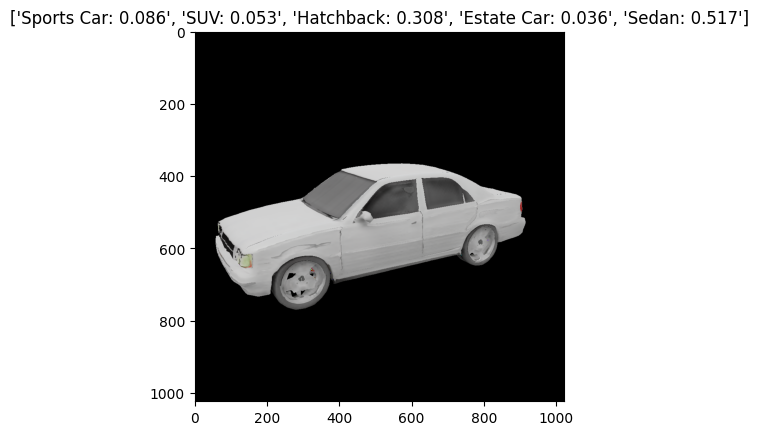

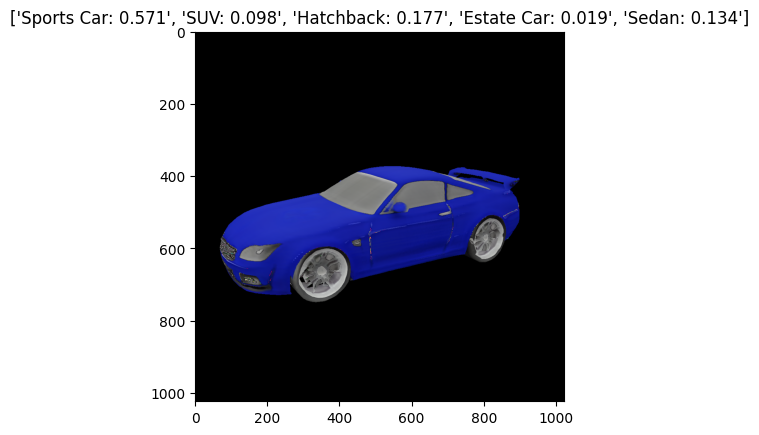

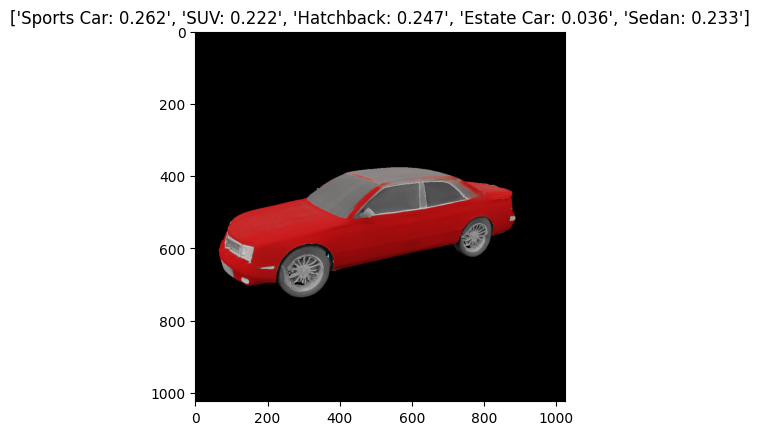

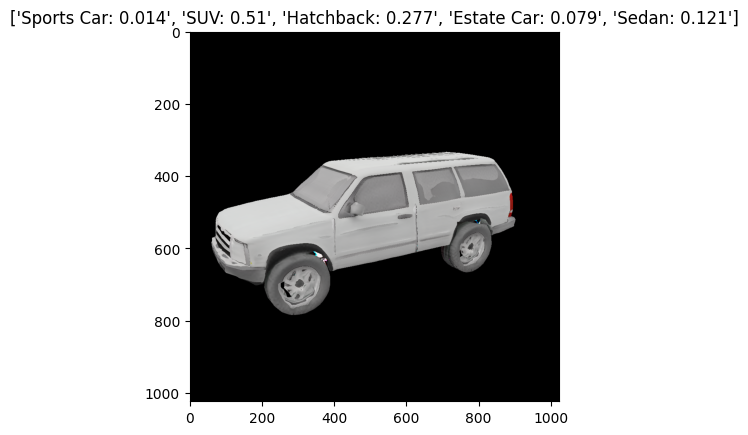

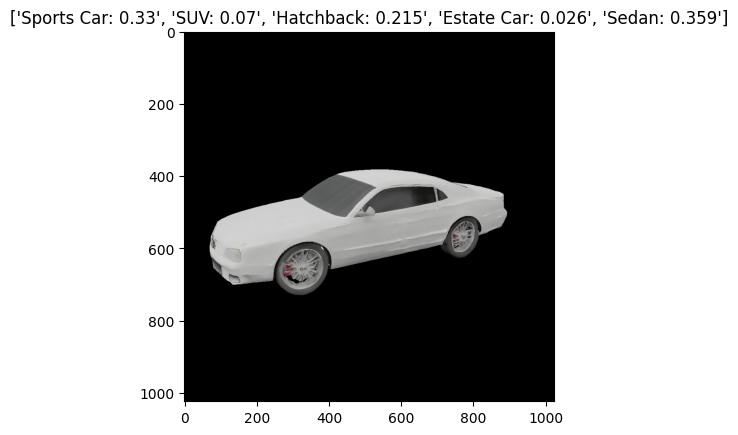

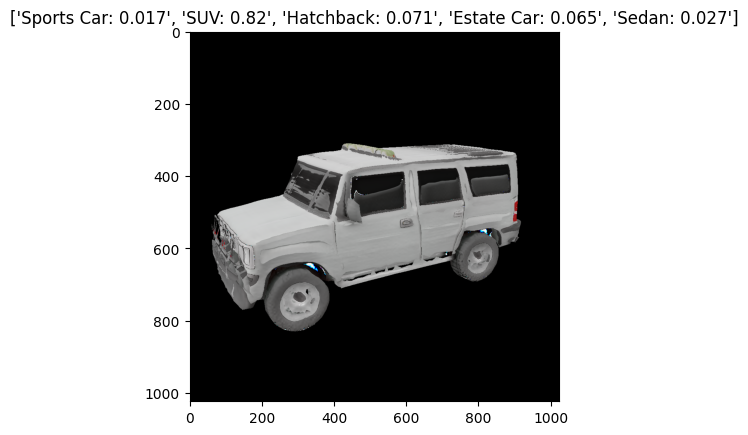

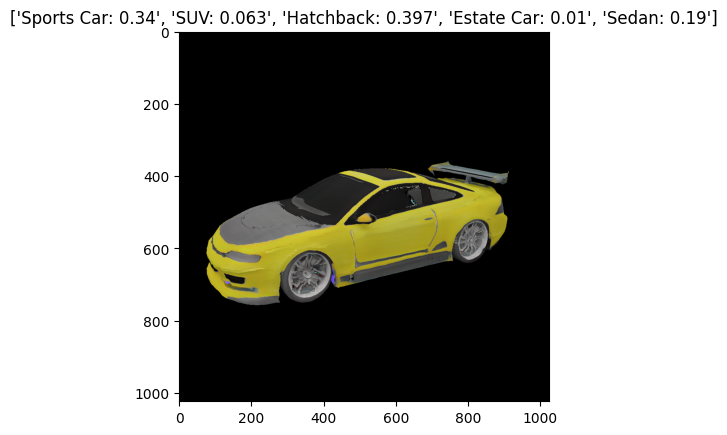

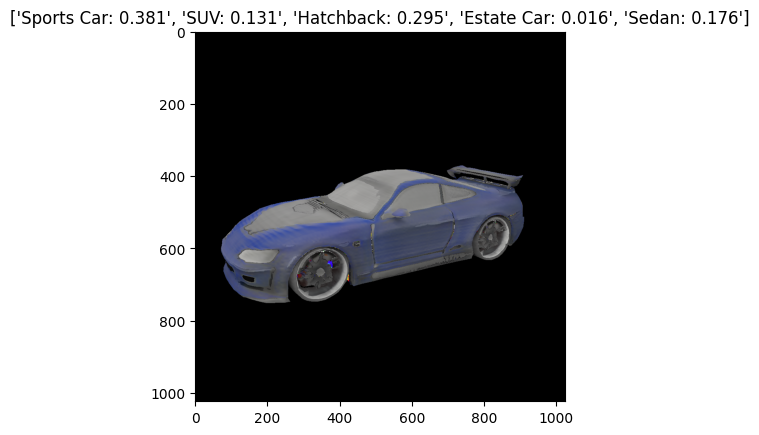

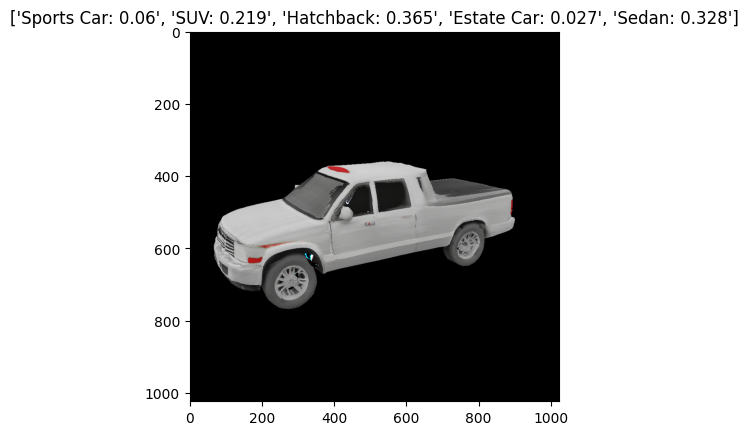

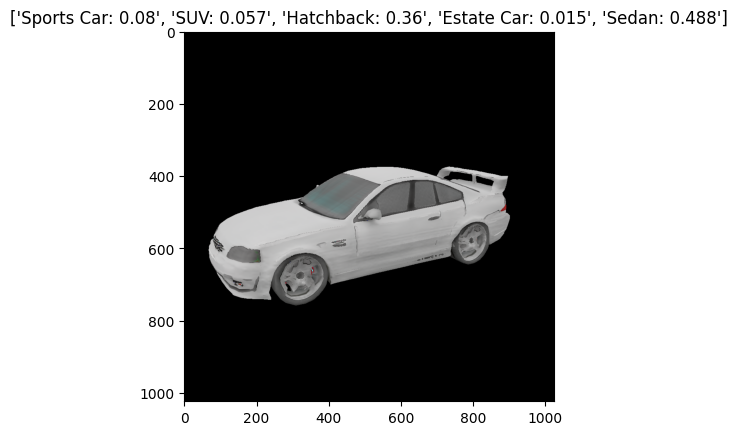

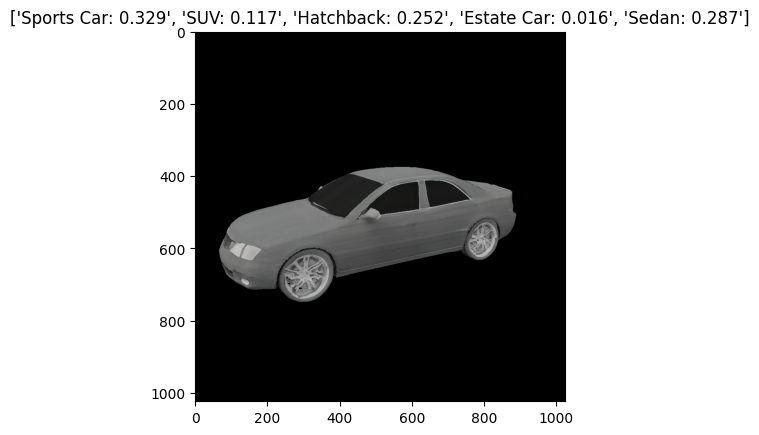

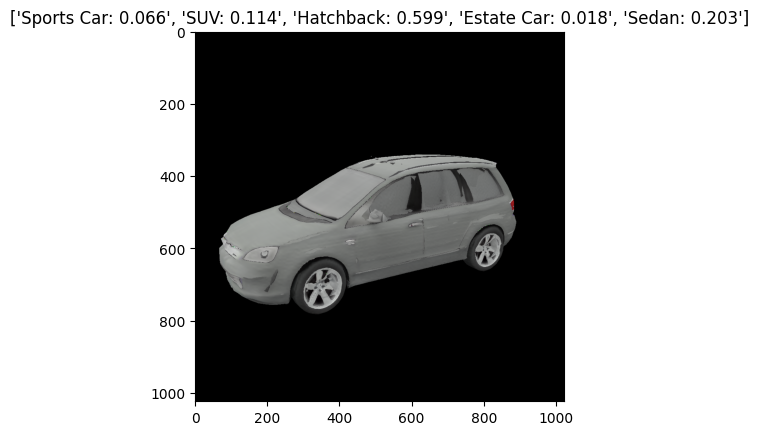

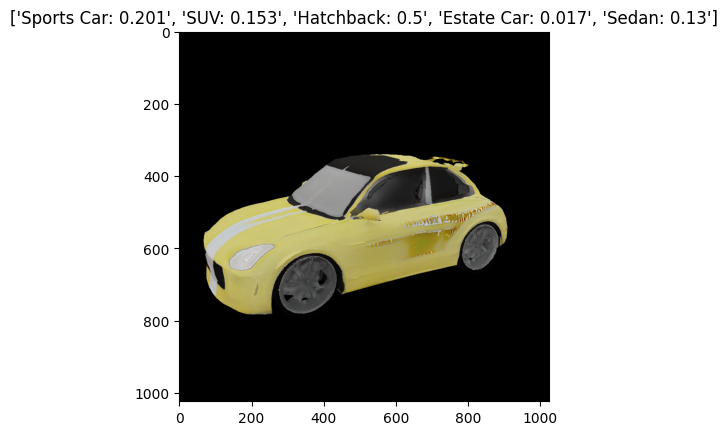

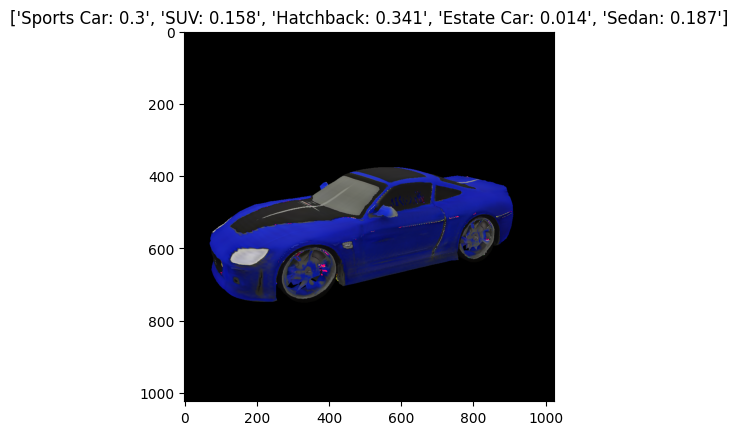

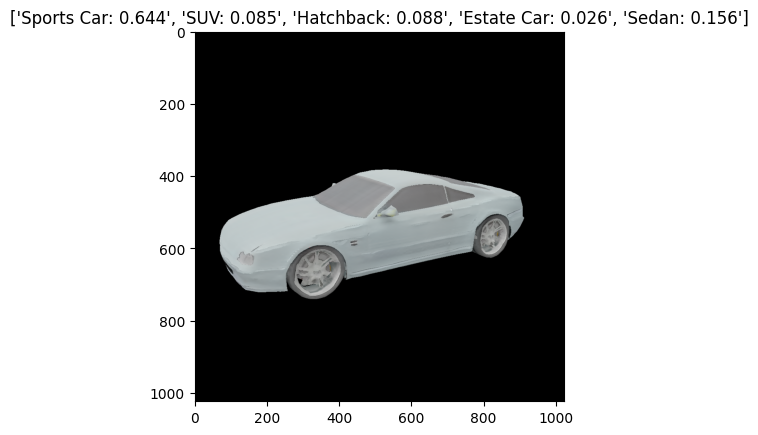

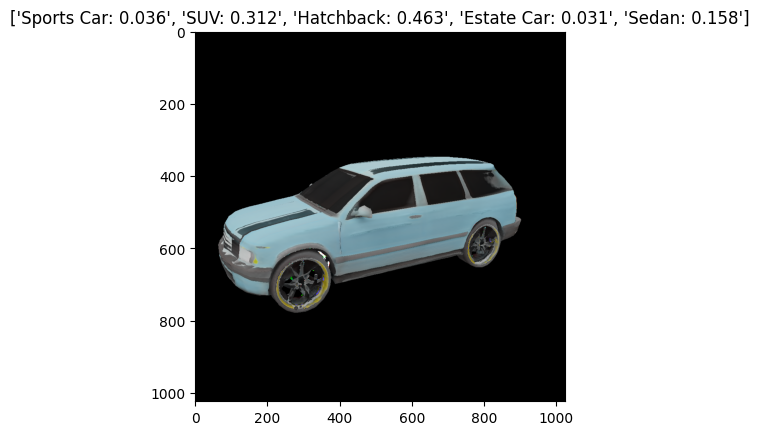

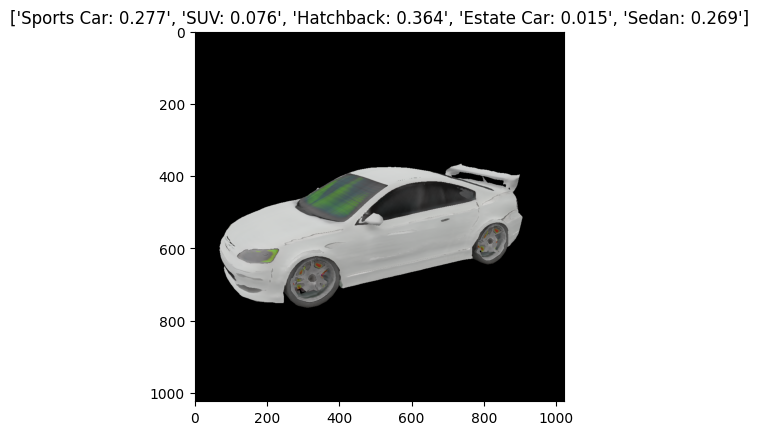

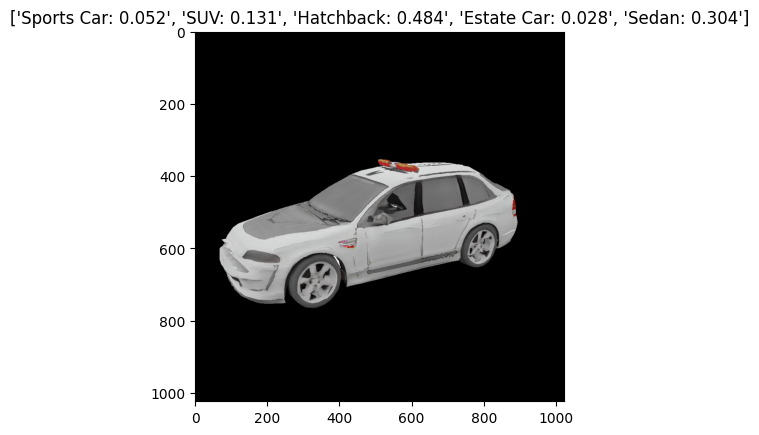

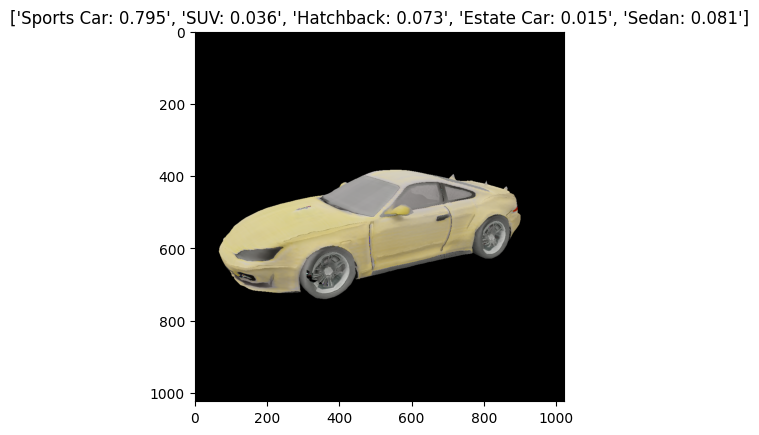

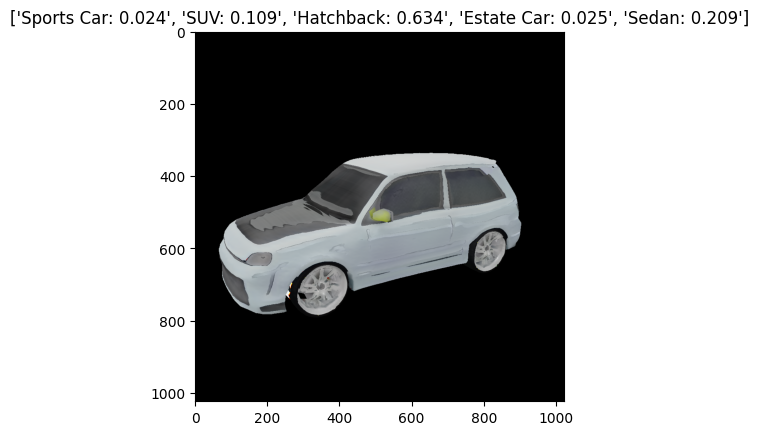

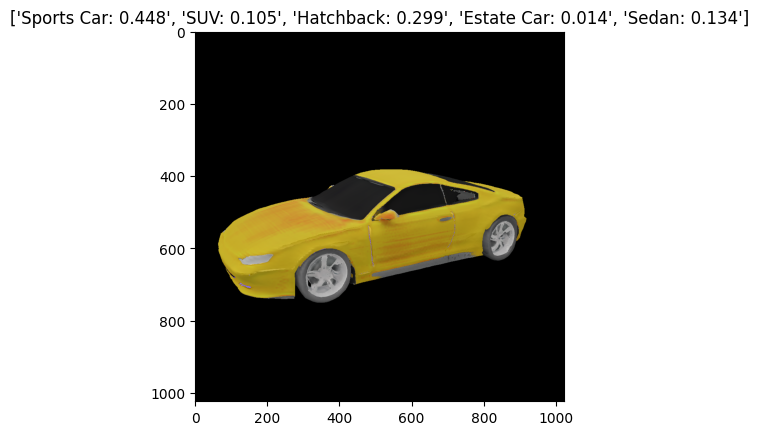

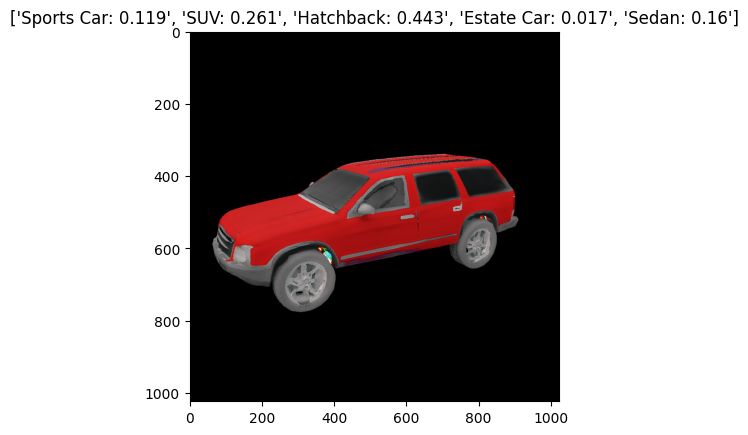

In [154]:
import math

text_prompts = ['Sports', 'SUV', 'Hatchback', 'Estate Car', 'Sedan']
text = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    for i, img in enumerate(imgs):
        img_processed = preprocess_rgb_grid(img.cpu().numpy())
        img_pre_clip = img_array[i]
        logits_per_image, logits_per_text = clip_model(img_pre_clip, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        plt.title([f'{j}: {str(round(probs[0][i], 3))}' for i, j in enumerate(text_prompts)])
        plt.imshow(img_processed)
        plt.show()

In [ ]:
import math

text_prompts = ['Sports Car', 'SUV', 'Hatchback', 'Estate Car', 'Sedan']
text = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    for i, img in enumerate(imgs):
        img_processed = preprocess_rgb_grid(img.cpu().numpy())
        img_pre_clip = img_array[i]
        logits_per_image, logits_per_text = clip_model(img_pre_clip, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        plt.title([f'{j}: {str(round(probs[0][i], 3))}' for i, j in enumerate(text_prompts)])
        plt.imshow(img_processed)
        plt.show()